### In this script, DBN is run on the all sessions separately
### In this script, DBN is run with 1s time bin, 3 time lag 
### In this script, DBN is run with sucessful and failed pulls seperately
### In this script, the animal tracking is done with only one camera - camera 2 (middle) 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn
import scipy
import scipy.stats as st
from sklearn.neighbors import KernelDensity
import string
import warnings
import pickle

import os
import glob
import random
from time import time

from pgmpy.models import BayesianModel
from pgmpy.models import DynamicBayesianNetwork as DBN
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import HillClimbSearch,BicScore
from pgmpy.base import DAG
import networkx as nx


### function - get body part location for each pair of cameras

In [2]:
from ana_functions.body_part_locs_eachpair import body_part_locs_eachpair
from ana_functions.body_part_locs_singlecam import body_part_locs_singlecam

### function - align the two cameras

In [3]:
from ana_functions.camera_align import camera_align       

### function - merge the two pairs of cameras

In [4]:
from ana_functions.camera_merge import camera_merge

### function - find social gaze time point

In [5]:
from ana_functions.find_socialgaze_timepoint import find_socialgaze_timepoint
from ana_functions.find_socialgaze_timepoint_singlecam import find_socialgaze_timepoint_singlecam
from ana_functions.find_socialgaze_timepoint_singlecam_wholebody import find_socialgaze_timepoint_singlecam_wholebody

### function - define time point of behavioral events

In [6]:
from ana_functions.bhv_events_timepoint import bhv_events_timepoint
from ana_functions.bhv_events_timepoint_singlecam import bhv_events_timepoint_singlecam

### function - plot behavioral events

In [7]:
from ana_functions.plot_bhv_events import plot_bhv_events
from ana_functions.plot_bhv_events_levertube import plot_bhv_events_levertube
from ana_functions.draw_self_loop import draw_self_loop
import matplotlib.patches as mpatches 
from matplotlib.collections import PatchCollection

### function - plot inter-pull interval

In [8]:
from ana_functions.plot_interpull_interval import plot_interpull_interval

### function - make demo videos with skeleton and inportant vectors

In [9]:
from ana_functions.tracking_video_singlecam_demo import tracking_video_singlecam_demo
from ana_functions.tracking_video_singlecam_wholebody_demo import tracking_video_singlecam_wholebody_demo

### function - interval between all behavioral events

In [10]:
from ana_functions.bhv_events_interval import bhv_events_interval

### function - train the dynamic bayesian network - multi time lag (3 lags)

In [11]:
from ana_functions.train_DBN_multiLag import train_DBN_multiLag
from ana_functions.train_DBN_multiLag import train_DBN_multiLag_create_df_only
from ana_functions.train_DBN_multiLag import train_DBN_multiLag_training_only
from ana_functions.train_DBN_multiLag import graph_to_matrix
from ana_functions.train_DBN_multiLag import get_weighted_dags
from ana_functions.train_DBN_multiLag import get_significant_edges
from ana_functions.train_DBN_multiLag import threshold_edges
from ana_functions.train_DBN_multiLag import Modulation_Index
from ana_functions.EfficientTimeShuffling import EfficientShuffle
from ana_functions.AicScore import AicScore

### function - cross correlation

In [12]:
from ana_functions.xcorr import xcorr
from ana_functions.xcorr import correlagram

## Analyze each session

### prepare the basic behavioral data (especially the time stamps for each bhv events)

In [13]:
# instead of using gaze angle threshold, use the target rectagon to deside gaze info
# ...need to update
sqr_thres_tubelever = 75 # draw the square around tube and lever
sqr_thres_face = 1.15 # a ratio for defining face boundary
sqr_thres_body = 4 # how many times to enlongate the face box boundry to the body


# get the fps of the analyzed video
fps = 30

# frame number of the demo video
# nframes = 0.5*30 # second*30fps
nframes = 5*30 # second*30fps

# re-analyze the video or not
reanalyze_video = 0
redo_anystep = 0

# only analyze the best (five) sessions for each conditions
do_bestsession = 1
if do_bestsession:
    savefile_sufix = '_bestsessions'
else:
    savefile_sufix = ''
    
# all the videos (no misaligned ones)
# aligned with the audio
# get the session start time from "videosound_bhv_sync.py/.ipynb"
# currently the session_start_time will be manually typed in. It can be updated after a better method is used

# dodson scorch
if 1:
    if not do_bestsession:
        dates_list = [
                      "20220909","20220912","20220915","20220920","20220922","20220923","20221010",
                      "20221011","20221013","20221014","20221015","20221017","20230215",     
                      "20221018","20221019","20221020","20221021","20221022","20221026","20221028","20221030",
                      "20221107","20221108","20221109","20221110","20221111","20221114","20221115","20221116",
                      "20221117","20221118","20221121","20221122","20221123","20221125","20221128","20221129",              
                      "20221205","20221206","20221209","20221212","20221214","20221216","20221219","20221220",
                      "20221221","20230208","20230209","20230213","20230214","20230111","20230112","20230201",

                     ]
        session_start_times = [ 
                                 6.50, 18.10, 0,      33.03, 549.0, 116.80, 6.50,
                                 2.80, 27.80, 272.50, 27.90, 27.00,  33.00,
                                28.70, 45.30, 21.10,  27.10, 51.90,  21.00, 30.80, 17.50,                      
                                15.70,  2.65, 27.30,   0.00,  0.00,  71.80,  0.00,  0.00, 
                                75.50, 20.20,  0.00,  24.20, 36.70,  26.40, 22.50, 28.50,                       
                                 0.00,  0.00, 21.70,  84.70, 17.00,  19.80, 23.50, 25.20,  
                                 0.00,  0.00,  0.00,   0.00,  0.00, 130.00, 14.20, 24.20, 
                              ] # in second
    elif do_bestsession:
        # pick only five sessions for each conditions
        dates_list = [
                      "20220912","20220915","20220920","20221010","20230208",
                      "20221011","20221013","20221015","20221017",
                      "20221022","20221026","20221028","20221030","20230209",
                      "20221125","20221128","20221129","20230214","20230215",                  
                      "20221205","20221206","20221209","20221214","20230112",
                      "20230117","20230118","20230124","20230126",
                     ]
        session_start_times = [ 
                                18.10,  0.00, 33.03,  6.50,  0.00, 
                                 2.80, 27.80, 27.90, 27.00,  
                                51.90, 21.00, 30.80, 17.50,  0.00,                    
                                26.40, 22.50, 28.50,  0.00, 33.00,                     
                                 0.00,  0.00, 21.70, 17.00, 14.20, 
                                 0.00,  0.00,  0.00,  0.00,  
                              ] # in second
    
    animal1_fixedorder = ['dodson']
    animal2_fixedorder = ['scorch']

    animal1_filename = "Dodson"
    animal2_filename = "Scorch"
    
# eddie sparkle
if 1:
    if not do_bestsession:
        dates_list = [
                      "20221122","20221125","20221128","20221129","20221130","20221202","20221206",
                      "20221207","20221208","20221209","20230126","20230127","20230130","20230201","20230203-1",
                      "20230206","20230207","20230208-1","20230209","20230222","20230223-1","20230227-1",
                      "20230228-1","20230302-1","20230307-2","20230313","20230315","20230316","20230317",
                      "20230321","20230322","20230324","20230327","20230328",
                      "20230330","20230331","20230403","20230404","20230405","20230406","20230407",
                      
                   ]
        session_start_times = [ 
                                 8.00,38.00,1.00,3.00,5.00,9.50,1.00,
                                 4.50,4.50,5.00,38.00,166.00,4.20,3.80,3.60,
                                 7.50,9.00,7.50,8.50,14.50,7.80,8.00,7.50,
                                 8.00,8.00,4.00,123.00,14.00,8.80,
                                 7.00,7.50,5.50,11.00,9.00,
                                 17.00,4.50,9.30,25.50,20.40,21.30,24.80,
                                 
                              ] # in second
    elif do_bestsession:   
        dates_list = [
                      "20221122",  "20221125",  
                      "20221202",  "20221206",  "20230126",  "20230130",  "20230201",
                      "20230207",  "20230208-1","20230209",  "20230222",  "20230223-1",
                      "20230227-1","20230228-1","20230302-1","20230307-2","20230313",
                      "20230321",  "20230322",  "20230324",  "20230327",  "20230328",
                      "20230331",  "20230403",  "20230404",  "20230405",  "20230406"
                   ]
        session_start_times = [ 
                                  8.00,  38.00, 
                                  9.50,   1.00, 38.00,  4.20,  3.80,
                                  9.00,   7.50,  8.50, 14.50,  7.80,
                                  8.00,   7.50,  8.00,  8.00,  4.00,
                                  7.00,   7.50,  5.50, 11.00,  9.00,
                                  4.50,   9.30, 25.50, 20.40, 21.30,
                              ] # in second
    
    animal1_fixedorder = ['eddie']
    animal2_fixedorder = ['sparkle']

    animal1_filename = "Eddie"
    animal2_filename = "Sparkle"
    
# ginger kanga
if 1:
    if not do_bestsession:
        dates_list = [
                      "20230209","20230213","20230214","20230216","20230222","20230223","20230228","20230302",
                      "20230303","20230307","20230314","20230315","20230316","20230317"         
                   ]
        session_start_times = [ 
                                 0.00,  0.00,  0.00, 48.00, 26.20, 18.00, 23.00, 28.50,
                                34.00, 25.50, 25.50, 31.50, 28.00, 30.50
                              ] # in second 
    elif do_bestsession:   
        dates_list = [
                      "20230213","20230214","20230216",
                      "20230228","20230302","20230303","20230307",          
                      "20230314","20230315","20230316","20230317",
                      "20230301","20230320","20230321","20230322",
                      "20230323","20230412","20230413","20230517","20230614","20230615",
                      "20230522_ws","20230524","20230605_1","20230606","20230607"
                   ]
        session_start_times = [ 
                                 0.00,  0.00, 48.00, 
                                23.00, 28.50, 34.00, 25.50, 
                                25.50, 31.50, 28.00, 30.50,
                                33.50, 22.20, 50.00,  0.00, 
                                33.00, 18.20, 22.80, 31.00, 24.00, 21.00,
                                 0.00,  0.00,  0.00,  0.00,  0.00,
                              ] # in second 
    
    animal1_fixedorder = ['ginger']
    animal2_fixedorder = ['kanga']

    animal1_filename = "Ginger"
    animal2_filename = "Kanga"

# dannon kanga
if 0:
    if not do_bestsession:
        dates_list = [
                      "20230718","20230720","20230914","20230829","20230907","20230915",
                      "20230918","20230926","20230928","20231002","20231010","20231011",
                      "20231013",
                   ]
        session_start_times = [ 
                                 0, 0, 0, 0, 0, 0, 
                                 0, 0, 0, 0, 0, 0,
                                 0,
                              ] # in second 
    elif do_bestsession:   
        dates_list = [
                      "20230718","20230720","20230914","20230829","20230907","20230915",
                      "20230918","20230926","20230928","20231002","20231010","20231011",
                      "20231013", 
                   ]
        session_start_times = [ 
                                 0, 0, 0, 0, 0, 0, 
                                 0, 0, 0, 0, 0, 0,
                                 0,
                              ] # in second 
    
    animal1_fixedorder = ['dannon']
    animal2_fixedorder = ['kanga']

    animal1_filename = "Dannon"
    animal2_filename = "Kanga"
    
#    
#dates_list = ["20221128"]
#session_start_times = [1.00] # in second
ndates = np.shape(dates_list)[0]

session_start_frames = session_start_times * fps # fps is 30Hz

totalsess_time = 600

# video tracking results info
animalnames_videotrack = ['dodson','scorch'] # does not really mean dodson and scorch, instead, indicate animal1 and animal2
bodypartnames_videotrack = ['rightTuft','whiteBlaze','leftTuft','rightEye','leftEye','mouth']


# which camera to analyzed
cameraID = 'camera-2'
cameraID_short = 'cam2'


# location of levers and tubes for camera 2
# get this information using DLC animal tracking GUI, the results are stored: 
# /home/ws523/marmoset_tracking_DLCv2/marmoset_tracking_with_lever_tube-weikang-2023-04-13/labeled-data/
considerlevertube = 1
considertubeonly = 0
# # camera 1
# lever_locs_camI = {'dodson':np.array([645,600]),'scorch':np.array([425,435])}
# tube_locs_camI  = {'dodson':np.array([1350,630]),'scorch':np.array([555,345])}
# # camera 2
lever_locs_camI = {'dodson':np.array([1335,715]),'scorch':np.array([550,715])}
tube_locs_camI  = {'dodson':np.array([1550,515]),'scorch':np.array([350,515])}
# # lever_locs_camI = {'dodson':np.array([1335,715]),'scorch':np.array([550,715])}
# # tube_locs_camI  = {'dodson':np.array([1650,490]),'scorch':np.array([250,490])}
# # camera 3
# lever_locs_camI = {'dodson':np.array([1580,440]),'scorch':np.array([1296,540])}
# tube_locs_camI  = {'dodson':np.array([1470,375]),'scorch':np.array([805,475])}


if np.shape(session_start_times)[0] != np.shape(dates_list)[0]:
    exit()

    
# define bhv events summarizing variables     
tasktypes_all_dates = np.zeros((ndates,1))
coopthres_all_dates = np.zeros((ndates,1))

succ_rate_all_dates = np.zeros((ndates,1))
interpullintv_all_dates = np.zeros((ndates,1))
trialnum_all_dates = np.zeros((ndates,1))

owgaze1_num_all_dates = np.zeros((ndates,1))
owgaze2_num_all_dates = np.zeros((ndates,1))
mtgaze1_num_all_dates = np.zeros((ndates,1))
mtgaze2_num_all_dates = np.zeros((ndates,1))
pull1_num_all_dates = np.zeros((ndates,1))
pull2_num_all_dates = np.zeros((ndates,1))

bhv_intv_all_dates = dict.fromkeys(dates_list, [])


# where to save the summarizing data
data_saved_folder = '/gpfs/gibbs/pi/jadi/VideoTracker_SocialInter/3d_recontruction_analysis_self_and_coop_task_data_saved/'


    

In [14]:
# basic behavior analysis (define time stamps for each bhv events, etc)

try:
    if redo_anystep:
        dummy
    
    # load saved data
    data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    
    with open(data_saved_subfolder+'/owgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        owgaze1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/owgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        owgaze2_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/mtgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        mtgaze1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/mtgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        mtgaze2_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/pull1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        pull1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/pull2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        pull2_num_all_dates = pickle.load(f)

    with open(data_saved_subfolder+'/tasktypes_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        tasktypes_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/coopthres_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        coopthres_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/succ_rate_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        succ_rate_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/interpullintv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        interpullintv_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/trialnum_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        trialnum_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/bhv_intv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        bhv_intv_all_dates = pickle.load(f)

    print('all data from all dates are loaded')

except:

    print('analyze all dates')

    for idate in np.arange(0,ndates,1):
        date_tgt = dates_list[idate]
        session_start_time = session_start_times[idate]

        # folder and file path
        camera12_analyzed_path = "/gpfs/gibbs/pi/jadi/VideoTracker_SocialInter/test_video_cooperative_task_3d/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_camera12/"
        camera23_analyzed_path = "/gpfs/gibbs/pi/jadi/VideoTracker_SocialInter/test_video_cooperative_task_3d/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_camera23/"
        
        singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_cameraSep1shuffle1_150000"
        try: 
            bodyparts_camI_camIJ = camera12_analyzed_path+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
            # get the bodypart data from files
            bodyparts_locs_camI = body_part_locs_singlecam(bodyparts_camI_camIJ,singlecam_ana_type,animalnames_videotrack,bodypartnames_videotrack,date_tgt)
            video_file_original = camera12_analyzed_path+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+".mp4"
        except:
            bodyparts_camI_camIJ = camera23_analyzed_path+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
            # get the bodypart data from files
            bodyparts_locs_camI = body_part_locs_singlecam(bodyparts_camI_camIJ,singlecam_ana_type,animalnames_videotrack,bodypartnames_videotrack,date_tgt)
            video_file_original = camera23_analyzed_path+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+".mp4"        
        
        
        # load behavioral results
        try:
            bhv_data_path = "/home/ws523/marmoset_tracking_bhv_data_from_task_code/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
            trial_record_json = glob.glob(bhv_data_path +date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_TrialRecord_" + "*.json")
            bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_bhv_data_" + "*.json")
            session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_session_info_" + "*.json")
            #
            trial_record = pd.read_json(trial_record_json[0])
            bhv_data = pd.read_json(bhv_data_json[0])
            session_info = pd.read_json(session_info_json[0])
        except:
            bhv_data_path = "/home/ws523/marmoset_tracking_bhv_data_from_task_code/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
            trial_record_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_TrialRecord_" + "*.json")
            bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_bhv_data_" + "*.json")
            session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_session_info_" + "*.json")
            #
            trial_record = pd.read_json(trial_record_json[0])
            bhv_data = pd.read_json(bhv_data_json[0])
            session_info = pd.read_json(session_info_json[0])

        # get animal info from the session information
        animal1 = session_info['lever1_animal'][0].lower()
        animal2 = session_info['lever2_animal'][0].lower()

        
        # get task type and cooperation threshold
        try:
            coop_thres = session_info["pulltime_thres"][0]
            tasktype = session_info["task_type"][0]
        except:
            coop_thres = 0
            tasktype = 1
        tasktypes_all_dates[idate] = tasktype
        coopthres_all_dates[idate] = coop_thres   

        # clean up the trial_record
        warnings.filterwarnings('ignore')
        trial_record_clean = pd.DataFrame(columns=trial_record.columns)
        for itrial in np.arange(0,np.max(trial_record['trial_number']),1):
            # trial_record_clean.loc[itrial] = trial_record[trial_record['trial_number']==itrial+1].iloc[[0]]
            trial_record_clean = trial_record_clean.append(trial_record[trial_record['trial_number']==itrial+1].iloc[[0]])
        trial_record_clean = trial_record_clean.reset_index(drop = True)

        # change bhv_data time to the absolute time
        time_points_new = pd.DataFrame(np.zeros(np.shape(bhv_data)[0]),columns=["time_points_new"])
        for itrial in np.arange(0,np.max(trial_record_clean['trial_number']),1):
            ind = bhv_data["trial_number"]==itrial+1
            new_time_itrial = bhv_data[ind]["time_points"] + trial_record_clean["trial_starttime"].iloc[itrial]
            time_points_new["time_points_new"][ind] = new_time_itrial
        bhv_data["time_points"] = time_points_new["time_points_new"]
        bhv_data = bhv_data[bhv_data["time_points"] != 0]


        # analyze behavior results
        # succ_rate_all_dates[idate] = np.sum(trial_record_clean["rewarded"]>0)/np.shape(trial_record_clean)[0]
        succ_rate_all_dates[idate] = np.sum((bhv_data['behavior_events']==3)|(bhv_data['behavior_events']==4))/np.sum((bhv_data['behavior_events']==1)|(bhv_data['behavior_events']==2))
        trialnum_all_dates[idate] = np.shape(trial_record_clean)[0]
        #
        pullid = np.array(bhv_data[(bhv_data['behavior_events']==1) | (bhv_data['behavior_events']==2)]["behavior_events"])
        pulltime = np.array(bhv_data[(bhv_data['behavior_events']==1) | (bhv_data['behavior_events']==2)]["time_points"])
        pullid_diff = np.abs(pullid[1:] - pullid[0:-1])
        pulltime_diff = pulltime[1:] - pulltime[0:-1]
        interpull_intv = pulltime_diff[pullid_diff==1]
        interpull_intv = interpull_intv[interpull_intv<10]
        mean_interpull_intv = np.nanmean(interpull_intv)
        std_interpull_intv = np.nanstd(interpull_intv)
        #
        interpullintv_all_dates[idate] = mean_interpull_intv
        # 
        pull1_num_all_dates[idate] = np.sum(bhv_data['behavior_events']==1) 
        pull2_num_all_dates[idate] = np.sum(bhv_data['behavior_events']==2)

        
        # load behavioral event results
        try:
            # dummy
            print('load social gaze with '+cameraID+' only of '+date_tgt)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_look_ornot.pkl', 'rb') as f:
                output_look_ornot = pickle.load(f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allvectors.pkl', 'rb') as f:
                output_allvectors = pickle.load(f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allangles.pkl', 'rb') as f:
                output_allangles = pickle.load(f)  
        except:   
            print('analyze social gaze with '+cameraID+' only of '+date_tgt)
            # get social gaze information 
            output_look_ornot, output_allvectors, output_allangles = find_socialgaze_timepoint_singlecam_wholebody(bodyparts_locs_camI,lever_locs_camI,tube_locs_camI,
                                                                                                                   considerlevertube,considertubeonly,sqr_thres_tubelever,
                                                                                                                   sqr_thres_face,sqr_thres_body)
            # save data
            current_dir = data_saved_folder+'/bhv_events_singlecam_wholebody/'+animal1_fixedorder[0]+animal2_fixedorder[0]
            add_date_dir = os.path.join(current_dir,cameraID+'/'+date_tgt)
            if not os.path.exists(add_date_dir):
                os.makedirs(add_date_dir)
            #
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_look_ornot.pkl', 'wb') as f:
                pickle.dump(output_look_ornot, f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allvectors.pkl', 'wb') as f:
                pickle.dump(output_allvectors, f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allangles.pkl', 'wb') as f:
                pickle.dump(output_allangles, f)
  

        look_at_other_or_not_merge = output_look_ornot['look_at_other_or_not_merge']
        look_at_tube_or_not_merge = output_look_ornot['look_at_tube_or_not_merge']
        look_at_lever_or_not_merge = output_look_ornot['look_at_lever_or_not_merge']
        # change the unit to second
        session_start_time = session_start_times[idate]
        look_at_other_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_other_or_not_merge['dodson'])[0],1)/fps - session_start_time
        look_at_lever_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_lever_or_not_merge['dodson'])[0],1)/fps - session_start_time
        look_at_tube_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_tube_or_not_merge['dodson'])[0],1)/fps - session_start_time 

        # find time point of behavioral events
        output_time_points_socialgaze ,output_time_points_levertube = bhv_events_timepoint_singlecam(bhv_data,look_at_other_or_not_merge,look_at_lever_or_not_merge,look_at_tube_or_not_merge)
        time_point_pull1 = output_time_points_socialgaze['time_point_pull1']
        time_point_pull2 = output_time_points_socialgaze['time_point_pull2']
        oneway_gaze1 = output_time_points_socialgaze['oneway_gaze1']
        oneway_gaze2 = output_time_points_socialgaze['oneway_gaze2']
        mutual_gaze1 = output_time_points_socialgaze['mutual_gaze1']
        mutual_gaze2 = output_time_points_socialgaze['mutual_gaze2']
            
                
        # # plot behavioral events
        if np.isin(animal1,animal1_fixedorder):
                plot_bhv_events(date_tgt,animal1, animal2, session_start_time, 600, time_point_pull1, time_point_pull2, oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2)
        else:
                plot_bhv_events(date_tgt,animal2, animal1, session_start_time, 600, time_point_pull2, time_point_pull1, oneway_gaze2, oneway_gaze1, mutual_gaze2, mutual_gaze1)
        #
        # save behavioral events plot
        if 0:
            current_dir = data_saved_folder+'/bhv_events_singlecam_wholebody/'+animal1_fixedorder[0]+animal2_fixedorder[0]
            add_date_dir = os.path.join(current_dir,cameraID+'/'+date_tgt)
            if not os.path.exists(add_date_dir):
                os.makedirs(add_date_dir)
            plt.savefig(data_saved_folder+"/bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/'+date_tgt+"_"+cameraID_short+".pdf")

        #
        owgaze1_num_all_dates[idate] = np.shape(oneway_gaze1)[0]
        owgaze2_num_all_dates[idate] = np.shape(oneway_gaze2)[0]
        mtgaze1_num_all_dates[idate] = np.shape(mutual_gaze1)[0]
        mtgaze2_num_all_dates[idate] = np.shape(mutual_gaze2)[0]

        # analyze the events interval, especially for the pull to other and other to pull interval
        # could be used for define time bin for DBN
        if 1:
            _,_,_,pullTOother_itv, otherTOpull_itv = bhv_events_interval(totalsess_time, session_start_time, time_point_pull1, time_point_pull2, 
                                                                         oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2)
            #
            pull_other_pool_itv = np.concatenate((pullTOother_itv,otherTOpull_itv))
            bhv_intv_all_dates[date_tgt] = {'pull_to_other':pullTOother_itv,'other_to_pull':otherTOpull_itv,
                            'pull_other_pooled': pull_other_pool_itv}
        
        # plot the tracking demo video
        if 1: 
            tracking_video_singlecam_wholebody_demo(bodyparts_locs_camI,output_look_ornot,output_allvectors,output_allangles,
                                              lever_locs_camI,tube_locs_camI,time_point_pull1,time_point_pull2,
                                              animalnames_videotrack,bodypartnames_videotrack,date_tgt,
                                              animal1_filename,animal2_filename,session_start_time,fps,nframes,cameraID,
                                              video_file_original,sqr_thres_tubelever,sqr_thres_face,sqr_thres_body)         
        

    # save data
    if 0:
        
        data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
        if not os.path.exists(data_saved_subfolder):
            os.makedirs(data_saved_subfolder)
                
        # with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
        #     pickle.dump(DBN_input_data_alltypes, f)

        with open(data_saved_subfolder+'/owgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(owgaze1_num_all_dates, f)
        with open(data_saved_subfolder+'/owgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(owgaze2_num_all_dates, f)
        with open(data_saved_subfolder+'/mtgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(mtgaze1_num_all_dates, f)
        with open(data_saved_subfolder+'/mtgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(mtgaze2_num_all_dates, f)
        with open(data_saved_subfolder+'/pull1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(pull1_num_all_dates, f)
        with open(data_saved_subfolder+'/pull2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(pull2_num_all_dates, f)

        with open(data_saved_subfolder+'/tasktypes_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(tasktypes_all_dates, f)
        with open(data_saved_subfolder+'/coopthres_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(coopthres_all_dates, f)
        with open(data_saved_subfolder+'/succ_rate_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(succ_rate_all_dates, f)
        with open(data_saved_subfolder+'/interpullintv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(interpullintv_all_dates, f)
        with open(data_saved_subfolder+'/trialnum_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(trialnum_all_dates, f)
        with open(data_saved_subfolder+'/bhv_intv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(bhv_intv_all_dates, f)
    

all data from all dates are loaded


#### redefine the tasktype and cooperation threshold to merge them together

In [15]:
# 100: self; 3: 3s coop; 2: 2s coop; 1.5: 1.5s coop; 1: 1s coop; -1: no-vision

tasktypes_all_dates[tasktypes_all_dates==5] = -1 # change the task type code for no-vision
coopthres_forsort = (tasktypes_all_dates-1)*coopthres_all_dates/2
coopthres_forsort[coopthres_forsort==0] = 100 # get the cooperation threshold for sorting

### prepare the input data for DBN

In [16]:
# define DBN related summarizing variables

pulltypes = ['succpull','failedpull']
npulltypes = np.shape(pulltypes)[0]

prepare_input_data = 0

DBN_input_data_alltypes = dict.fromkeys(pulltypes, [])

# DBN resolutions (make sure they are the same as in the later part of the code)
totalsess_time = 600 # total session time in s
# temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
temp_resolus = [1] # temporal resolution in the DBN model, eg: 0.5 means 500ms
ntemp_reses = np.shape(temp_resolus)[0]

mergetempRos = 0

# # train the dynamic bayesian network - Alec's model 
#   prepare the multi-session table; one time lag; multi time steps (temporal resolution) as separate files

# prepare the DBN input data
if prepare_input_data:
    
    for ipulltype in np.arange(0,npulltypes,1):
        pulltype = pulltypes[ipulltype]

        DBN_input_data_alltypes[pulltype] = dict.fromkeys(dates_list, [])
            
        for idate in np.arange(0,ndates,1):
            date_tgt = dates_list[idate]
            session_start_time = session_start_times[idate]
                 
            # load behavioral results
            try:
                bhv_data_path = "/home/ws523/marmoset_tracking_bhv_data_from_task_code/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
                trial_record_json = glob.glob(bhv_data_path +date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_TrialRecord_" + "*.json")
                bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_bhv_data_" + "*.json")
                session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_session_info_" + "*.json")
                #
                trial_record = pd.read_json(trial_record_json[0])
                bhv_data = pd.read_json(bhv_data_json[0])
                session_info = pd.read_json(session_info_json[0])
            except:
                bhv_data_path = "/home/ws523/marmoset_tracking_bhv_data_from_task_code/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
                trial_record_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_TrialRecord_" + "*.json")
                bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_bhv_data_" + "*.json")
                session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_session_info_" + "*.json")
                #
                trial_record = pd.read_json(trial_record_json[0])
                bhv_data = pd.read_json(bhv_data_json[0])
                session_info = pd.read_json(session_info_json[0])

                
            # separate successful and failed pulls
            if pulltype == 'succpull':
                trialnum_tgtpull = trial_record[trial_record['rewarded']>0]['trial_number'].reset_index(drop=True)
            elif pulltype == 'failedpull':
                trialnum_tgtpull = trial_record[trial_record['rewarded']==0]['trial_number'].reset_index(drop=True)
            bhv_data = bhv_data[bhv_data['trial_number'].isin(trialnum_tgtpull)]
            trial_record = trial_record[trial_record['trial_number'].isin(trialnum_tgtpull)]
            bhv_data = bhv_data.reset_index(drop=True)
            trial_record = trial_record.reset_index(drop=True)
                
            # get animal info
            animal1 = session_info['lever1_animal'][0].lower()
            animal2 = session_info['lever2_animal'][0].lower()

            # clean up the trial_record
            #try:
            warnings.filterwarnings('ignore')
            trial_record_clean = pd.DataFrame(columns=trial_record.columns)
            for itrial in trial_record['trial_number']:
                # trial_record_clean.loc[itrial] = trial_record[trial_record['trial_number']==itrial+1].iloc[[0]]
                trial_record_clean = trial_record_clean.append(trial_record[trial_record['trial_number']==itrial].iloc[[0]])
            trial_record_clean = trial_record_clean.reset_index(drop = True)

            # change bhv_data time to the absolute time
            time_points_new = pd.DataFrame(np.zeros(np.shape(bhv_data)[0]),columns=["time_points_new"])
            for itrial in trial_record_clean['trial_number']:
                ind = bhv_data["trial_number"]==itrial
                new_time_itrial = bhv_data[ind]["time_points"] + float(trial_record_clean[trial_record_clean['trial_number']==itrial]['trial_starttime'].iloc[0])
                time_points_new["time_points_new"][ind] = new_time_itrial
            bhv_data["time_points"] = time_points_new["time_points_new"]
            bhv_data = bhv_data[bhv_data["time_points"] != 0]
            #except:
            #    trial_record_clean = trial_record

            # get task type and cooperation threshold
            try:
                coop_thres = session_info["pulltime_thres"][0]
                tasktype = session_info["task_type"][0]
            except:
                coop_thres = 0
                tasktype = 1

            # load behavioral event results
            print('load social gaze with '+cameraID+' only of '+date_tgt)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_look_ornot.pkl', 'rb') as f:
                output_look_ornot = pickle.load(f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allvectors.pkl', 'rb') as f:
                output_allvectors = pickle.load(f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allangles.pkl', 'rb') as f:
                output_allangles = pickle.load(f)  
            #
            look_at_other_or_not_merge = output_look_ornot['look_at_other_or_not_merge']
            look_at_tube_or_not_merge = output_look_ornot['look_at_tube_or_not_merge']
            look_at_lever_or_not_merge = output_look_ornot['look_at_lever_or_not_merge']
            # change the unit to second
            session_start_time = session_start_times[idate]
            look_at_other_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_other_or_not_merge['dodson'])[0],1)/fps - session_start_time
            look_at_lever_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_lever_or_not_merge['dodson'])[0],1)/fps - session_start_time
            look_at_tube_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_tube_or_not_merge['dodson'])[0],1)/fps - session_start_time 

            # find time point of behavioral events
            output_time_points_socialgaze ,output_time_points_levertube = bhv_events_timepoint_singlecam(bhv_data,look_at_other_or_not_merge,look_at_lever_or_not_merge,look_at_tube_or_not_merge)
            time_point_pull1 = output_time_points_socialgaze['time_point_pull1']
            time_point_pull2 = output_time_points_socialgaze['time_point_pull2']
            oneway_gaze1 = output_time_points_socialgaze['oneway_gaze1']
            oneway_gaze2 = output_time_points_socialgaze['oneway_gaze2']
            mutual_gaze1 = output_time_points_socialgaze['mutual_gaze1']
            mutual_gaze2 = output_time_points_socialgaze['mutual_gaze2']   


            if mergetempRos:
                temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
                # use bhv event to decide temporal resolution
                #
                #low_lim,up_lim,_ = bhv_events_interval(totalsess_time, session_start_time, time_point_pull1, time_point_pull2, oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2)
                #temp_resolus = temp_resolus = np.arange(low_lim,up_lim,0.1)

            ntemp_reses = np.shape(temp_resolus)[0]           

            # try different temporal resolutions
            for temp_resolu in temp_resolus:
                bhv_df = []

                if np.isin(animal1,animal1_fixedorder):
                    bhv_df_itr,_,_ = train_DBN_multiLag_create_df_only(totalsess_time, session_start_time, temp_resolu, time_point_pull1, time_point_pull2, oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2)
                else:
                    bhv_df_itr,_,_ = train_DBN_multiLag_create_df_only(totalsess_time, session_start_time, temp_resolu, time_point_pull2, time_point_pull1, oneway_gaze2, oneway_gaze1, mutual_gaze2, mutual_gaze1)     

                if len(bhv_df)==0:
                    bhv_df = bhv_df_itr
                else:
                    bhv_df = pd.concat([bhv_df,bhv_df_itr])                   
                    bhv_df = bhv_df.reset_index(drop=True)        

                DBN_input_data_alltypes[pulltype][date_tgt] = bhv_df

    # save data
    if 1:
        data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_SuccAndFailedPull_allsessions'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
        if not os.path.exists(data_saved_subfolder):
            os.makedirs(data_saved_subfolder)
        if not mergetempRos:
            with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'sReSo.pkl', 'wb') as f:
                pickle.dump(DBN_input_data_alltypes, f)
        else:
            with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_mergeTempsReSo.pkl', 'wb') as f:
                pickle.dump(DBN_input_data_alltypes, f)     

## Plots that include all pairs
### same as the previous plot in the normal allsession plot, but change to successful and failed pulls
####  plot the coorelation between pull time, and social gaze time
#### pull <-> pull; within animal gaze -> pull; across animal pull -> gaze; within animal pull -> gaze

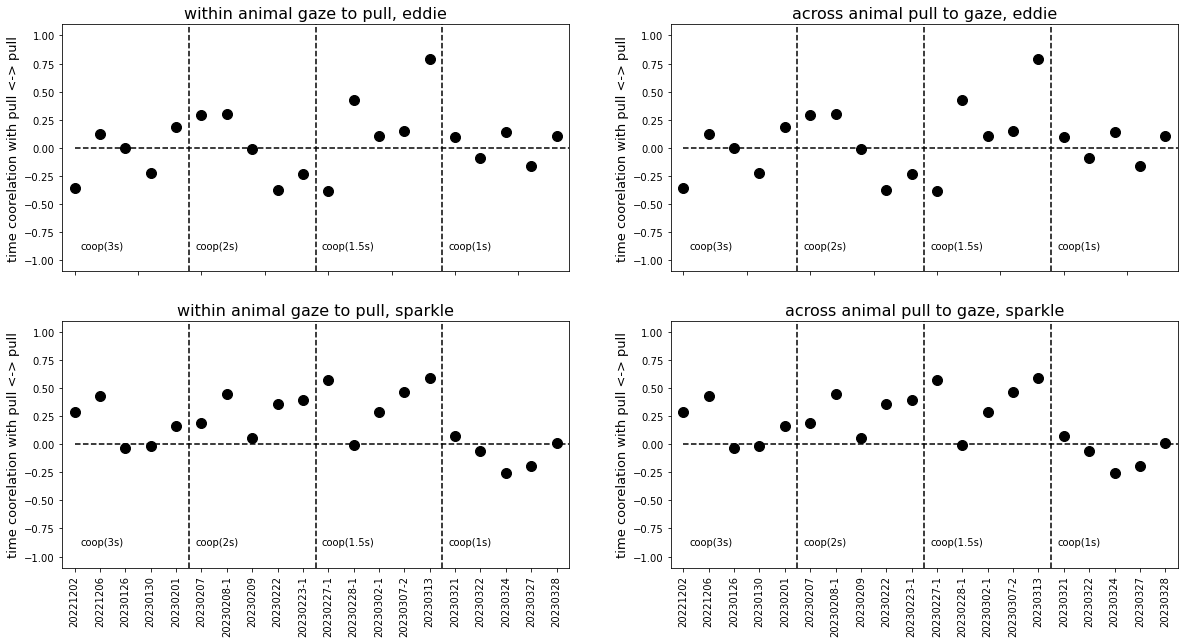

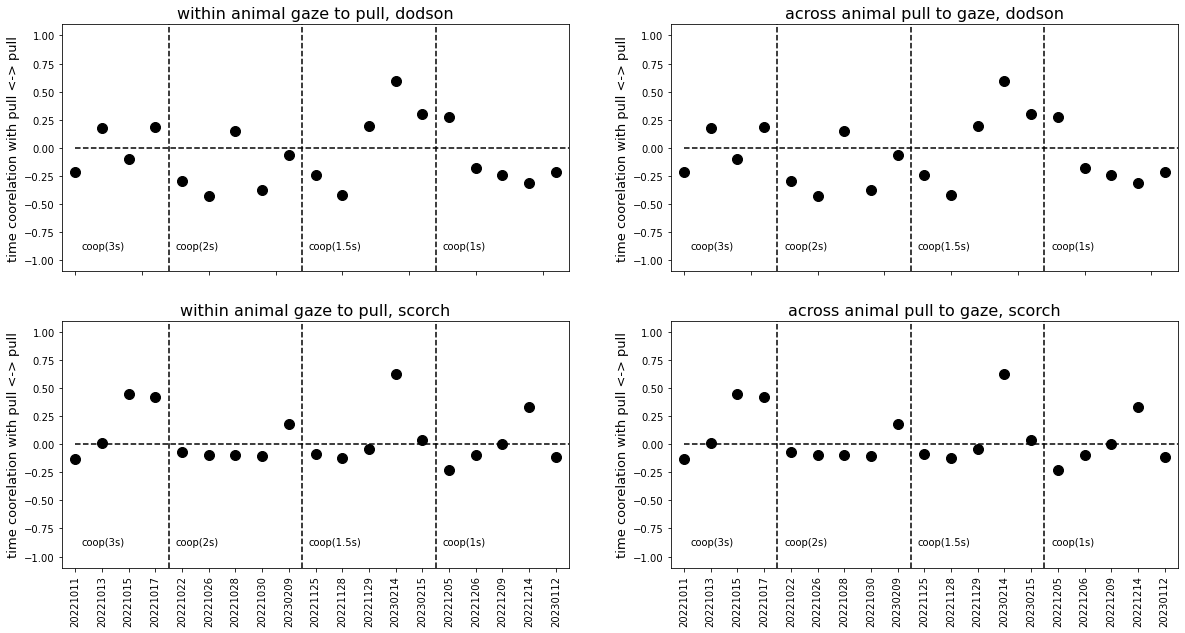

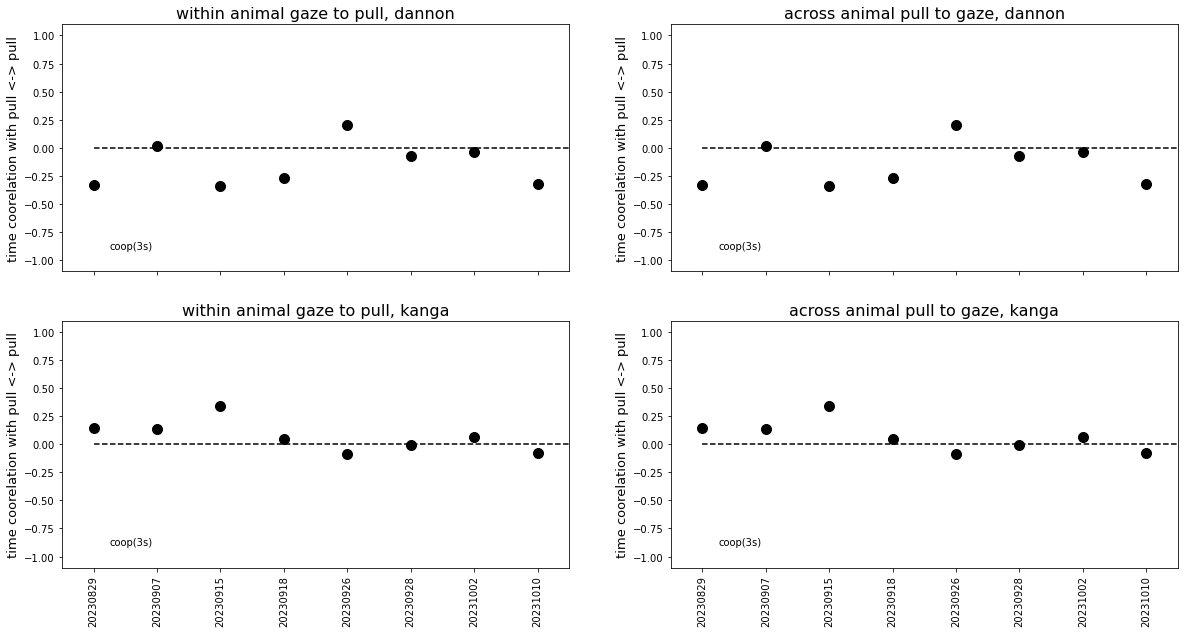

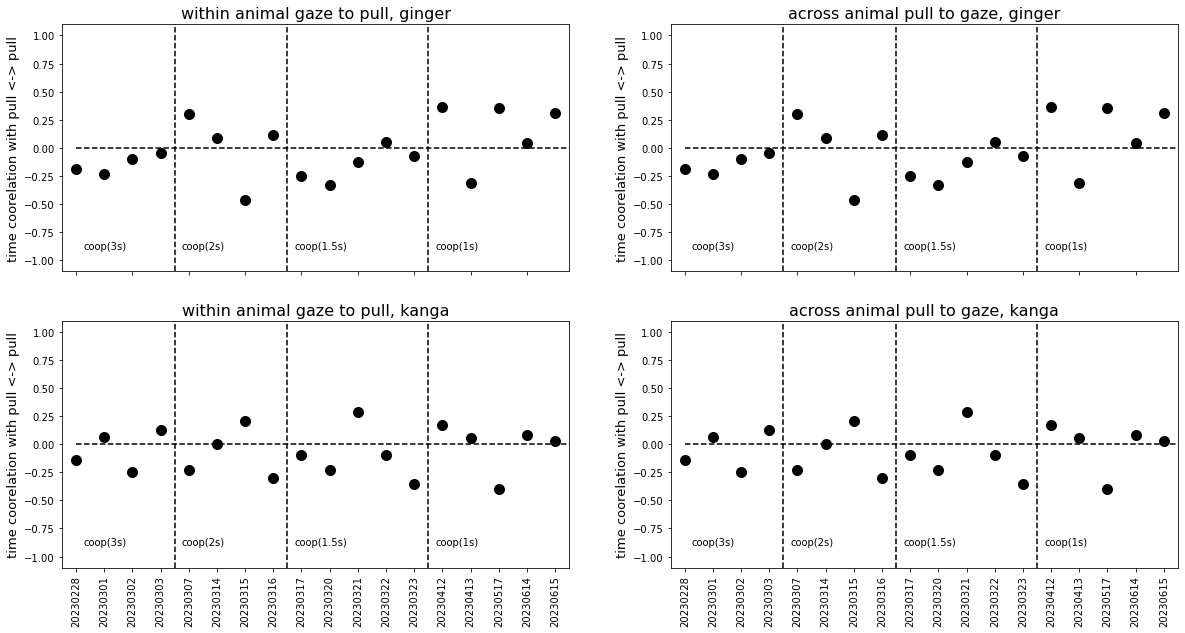

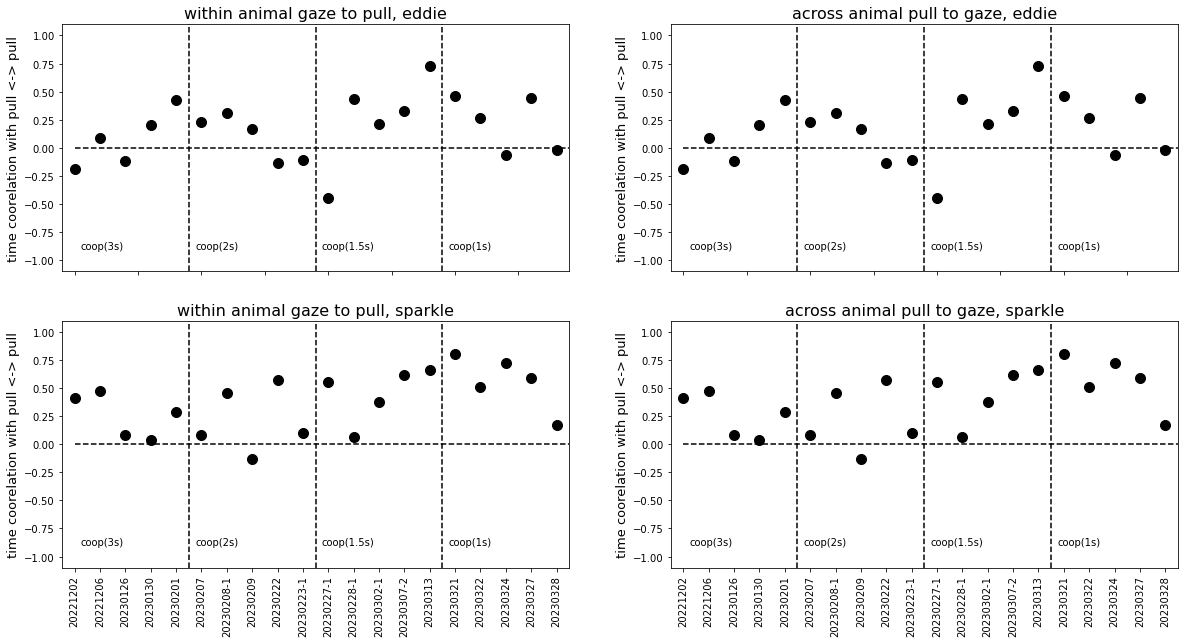

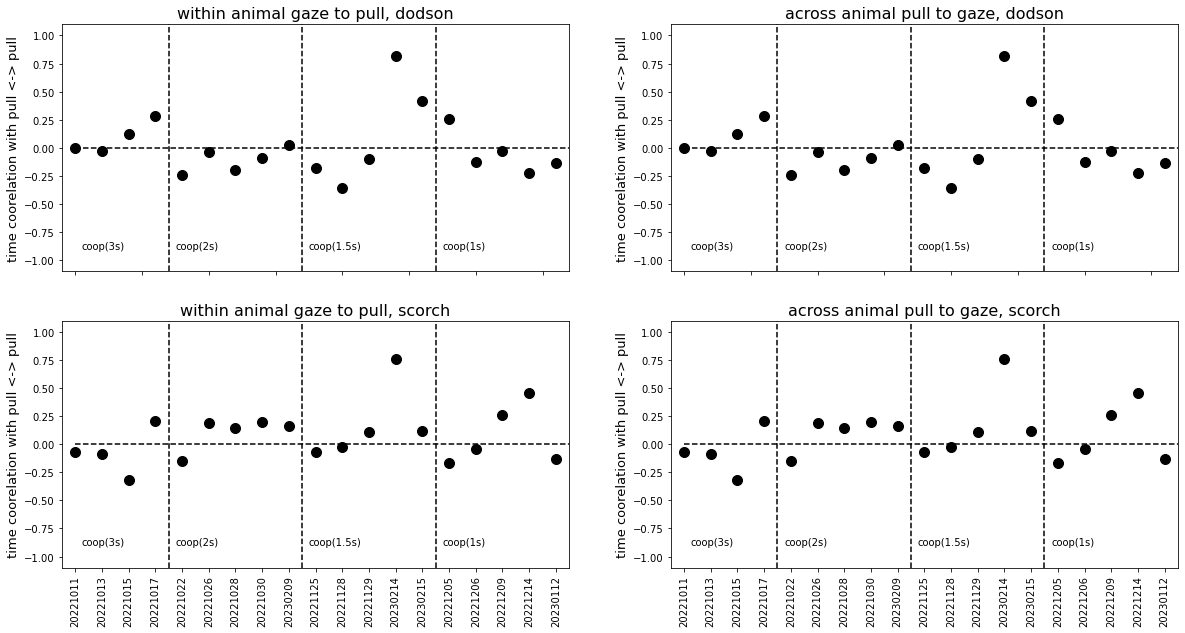

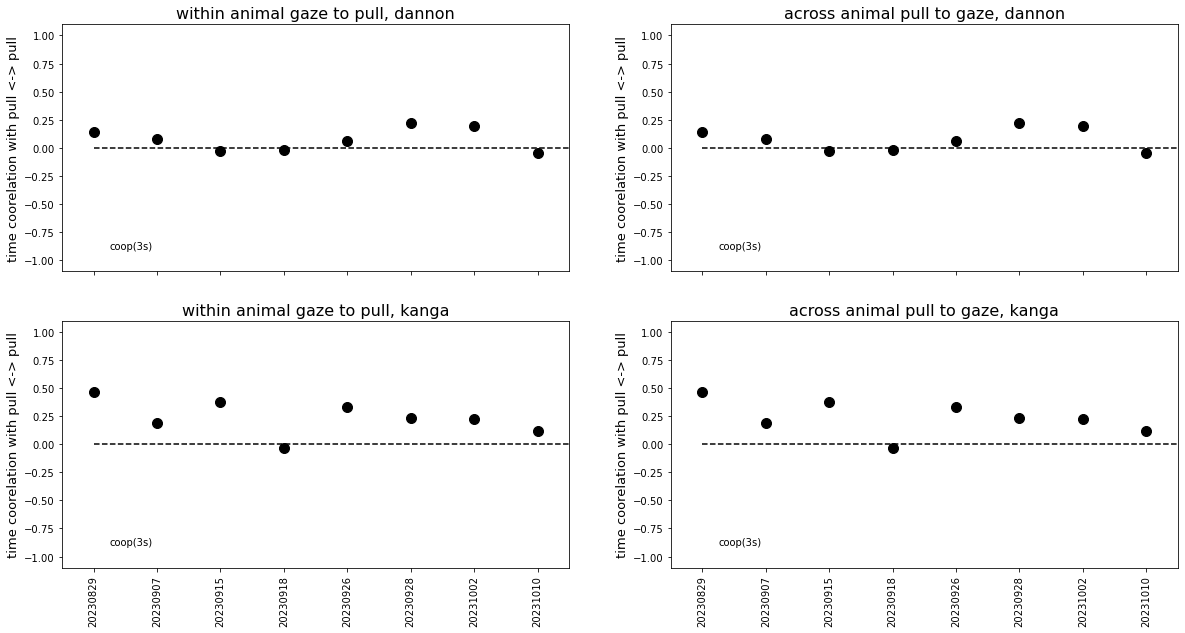

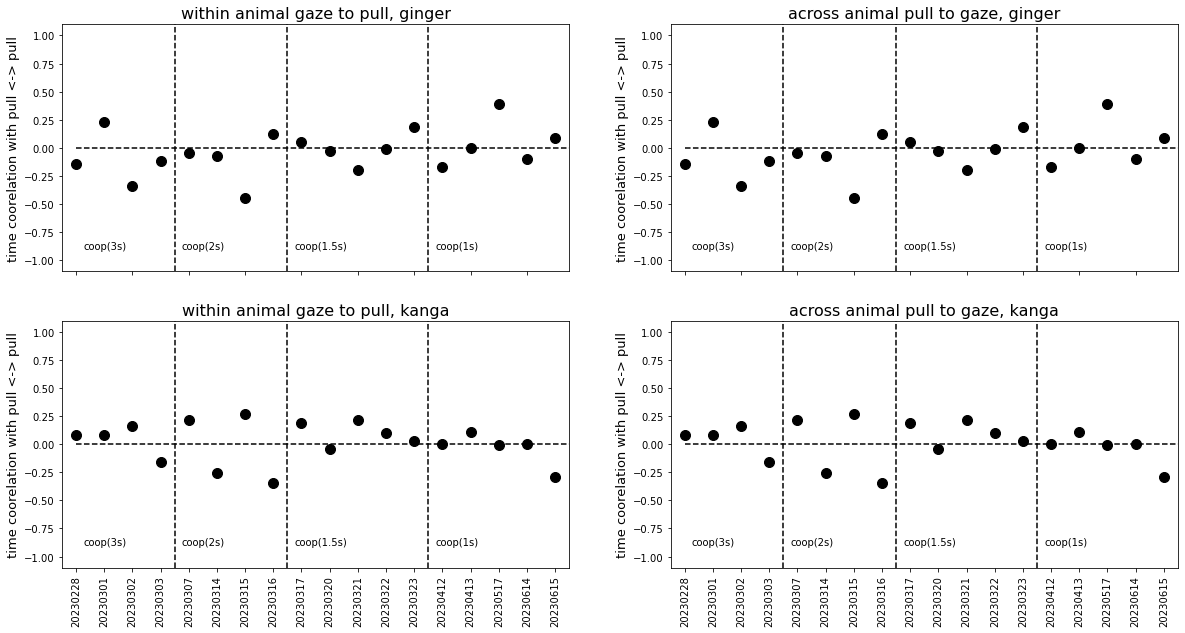

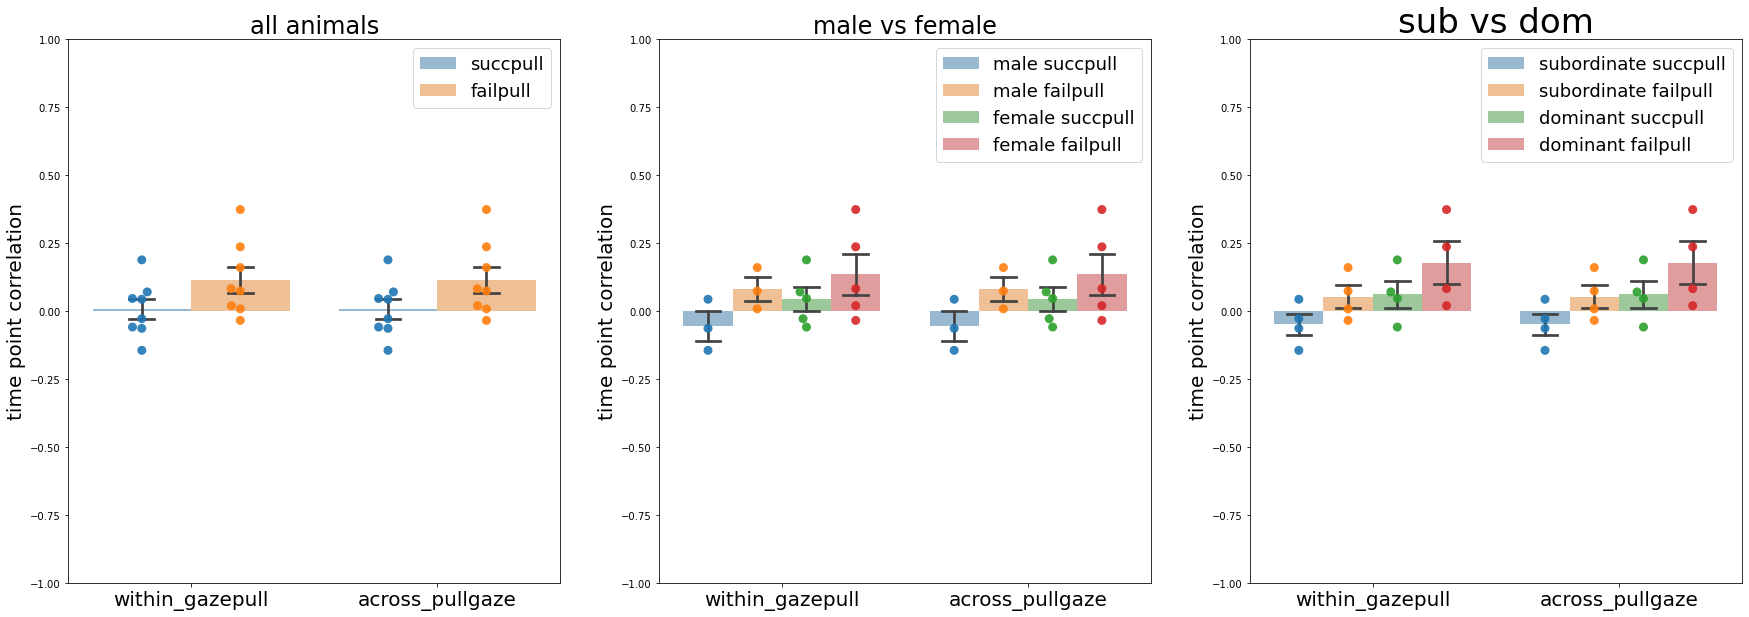

In [41]:
# PLOT multiple pairs in one plot, so need to load data seperately
mergetempRos = 0 # 1: merge different time bins
minmaxfullSampSize = 1 # 1: use the  min row number and max row number, or the full row for each session
moreSampSize = 0 # 1: use more sample size (more than just minimal row number and max row number)
#
animal1_fixedorders = ['eddie','dodson','dannon','ginger']
animal2_fixedorders = ['sparkle','scorch','kanga','kanga']
nanimalpairs = np.shape(animal1_fixedorders)[0]

temp_resolu = 1

succorfailpulls = ['succpull','failedpull']
nsuccorfail = np.shape(succorfailpulls)[0]

do_synedpulltime_pullgazetime = 0 # correlation between pairs of bhv events
do_pulltime_gazetime = 1 # correlation between single bhv events

# initiate the final data set
pull_gaze_time_corr_mean_all = dict.fromkeys(succorfailpulls,[])


for isuccorfail in np.arange(0,nsuccorfail,1):
    
    succorfailpull = succorfailpulls[isuccorfail]
    
    pull_gaze_time_corr_mean_all[succorfailpull] = np.zeros((nanimalpairs*2,2))


    for ianimalpair in np.arange(0,nanimalpairs,1):
        animal1_fixedorder = animal1_fixedorders[ianimalpair]
        animal2_fixedorder = animal2_fixedorders[ianimalpair]

        # load the basic behavioral measures
        # load saved data
        data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder+animal2_fixedorder+'/'
        #
        with open(data_saved_subfolder+'/owgaze1_num_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            owgaze1_num_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/owgaze2_num_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            owgaze2_num_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/mtgaze1_num_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            mtgaze1_num_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/mtgaze2_num_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            mtgaze2_num_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/pull1_num_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            pull1_num_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/pull2_num_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            pull2_num_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/tasktypes_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            tasktypes_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/coopthres_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            coopthres_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/succ_rate_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            succ_rate_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/interpullintv_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            interpullintv_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/trialnum_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            trialnum_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/bhv_intv_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            bhv_intv_all_dates = pickle.load(f)
        # 
        pullmean_num_all_dates = (pull1_num_all_dates+pull2_num_all_dates)/2
        #
        gaze1_num_all_dates = owgaze1_num_all_dates + mtgaze1_num_all_dates
        gaze2_num_all_dates = owgaze2_num_all_dates + mtgaze2_num_all_dates
        gazemean_num_all_dates = (gaze1_num_all_dates+gaze2_num_all_dates)/2

        # load the DBN related analysis
        # load data
        data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_allsessions'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder+animal2_fixedorder+'/'
        #
        if not mergetempRos:
            with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder+animal2_fixedorder+'_'+str(temp_resolu)+'sReSo.pkl', 'rb') as f:
                DBN_input_data_alltypes = pickle.load(f)
        else:
            with open(data_saved_subfolder+'//DBN_input_data_alltypes_'+animal1_fixedorder+animal2_fixedorder+'_mergeTempsReSo.pkl', 'rb') as f:
                DBN_input_data_alltypes = pickle.load(f)
        #
        # load data for successful and failed pulls
        data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_SuccAndFailedPull_allsessions'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder+animal2_fixedorder+'/'
        if not mergetempRos:
            with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder+animal2_fixedorder+'_'+str(temp_resolu)+'sReSo.pkl', 'rb') as f:
                DBN_input_data_alltypes_succfail = pickle.load(f)
        else:
            with open(data_saved_subfolder+'//DBN_input_data_alltypes_'+animal1_fixedorder+animal2_fixedorder+'_mergeTempsReSo.pkl', 'rb') as f:
                DBN_input_data_alltypes_succfail = pickle.load(f)

        #
        # re-organize the target dates
        # 100: self; 3: 3s coop; 2: 2s coop; 1.5: 1.5s coop; 1: 1s coop; -1: no-vision
        tasktypes_all_dates[tasktypes_all_dates==5] = -1 # change the task type code for no-vision
        coopthres_forsort = (tasktypes_all_dates-1)*coopthres_all_dates/2
        coopthres_forsort[coopthres_forsort==0] = 100 # get the cooperation threshold for sorting

        # temporily: for dannon/kanga, because some days were not analyzed for DBN
        if animal1_fixedorder == 'dannon':
            tasktypes_all_dates = tasktypes_all_dates[0:13]
            coopthres_forsort = coopthres_forsort[0:13]

        #
        # sort the data based on task type and dates
        dates_list = list(DBN_input_data_alltypes.keys())
        sorting_df = pd.DataFrame({'dates': dates_list, 'coopthres': coopthres_forsort.ravel()}, columns=['dates', 'coopthres'])
        sorting_df = sorting_df.sort_values(by=['coopthres','dates'], ascending = [False, True])
        #
        # only select the targeted dates
        sorting_tgt_df = sorting_df[(sorting_df['coopthres']==1)|(sorting_df['coopthres']==1.5)|(sorting_df['coopthres']==2)|(sorting_df['coopthres']==3)]
        # sorting_tgt_df = sorting_df[(sorting_df['coopthres']==1)]
        # sorting_tgt_df = sorting_df
        dates_list_tgt = sorting_tgt_df['dates']
        dates_list_tgt = np.array(dates_list_tgt)
        #
        ndates_tgt = np.shape(dates_list_tgt)[0]

        #
        # initiate the final data set
        within_pull_gaze_time_corr_all_ipair = dict.fromkeys(dates_list_tgt,[])
        across_pull_gaze_time_corr_all_ipair = dict.fromkeys(dates_list_tgt,[])
        within_pull_gaze_time_corP_all_ipair = dict.fromkeys(dates_list_tgt,[])
        across_pull_gaze_time_corP_all_ipair = dict.fromkeys(dates_list_tgt,[])


        for idate in np.arange(0,ndates_tgt,1):
            idate_name = dates_list_tgt[idate]

            DBN_input_data_idate_succfail = DBN_input_data_alltypes_succfail[succorfailpull][idate_name]
            DBN_input_data_idate = DBN_input_data_alltypes[idate_name]
            #
            if 0:
                # single behavioral events  
                # pull1_t0 and gaze1_t0
                xxx1 = (np.array(DBN_input_data_idate_succfail['pull1_t0'])==1)*1
                xxx2 = (np.array(DBN_input_data_idate['owgaze1_t0'])==1)*1
                rr1_spe,pp1_spe = scipy.stats.spearmanr(xxx1, xxx2)                 
                # pull2_t0 and gaze1_t0
                xxx1 = (np.array(DBN_input_data_idate_succfail['pull2_t0'])==1)*1
                xxx2 = (np.array(DBN_input_data_idate['owgaze1_t0'])==1)*1
                rr2_spe,pp2_spe = scipy.stats.spearmanr(xxx1, xxx2)            
                # pull2_t0 and gaze2_t0
                xxx1 = (np.array(DBN_input_data_idate_succfail['pull2_t0'])==1)*1
                xxx2 = (np.array(DBN_input_data_idate['owgaze2_t0'])==1)*1
                rr3_spe,pp3_spe = scipy.stats.spearmanr(xxx1, xxx2)           
                # pull1_t0 and gaze2_t0
                xxx1 = (np.array(DBN_input_data_idate_succfail['pull1_t0'])==1)*1
                xxx2 = (np.array(DBN_input_data_idate['owgaze2_t0'])==1)*1
                rr4_spe,pp4_spe = scipy.stats.spearmanr(xxx1, xxx2)
            #
            if do_pulltime_gazetime: # this is the best!
                kernel_size = 3
                # single behavioral events  
                # pull1_t0 and gaze1_t0
                #xxx1 = (np.array(DBN_input_data_idate_succfail['pull1_t0'])==1)*1
                xxx1 = ((np.array(DBN_input_data_idate_succfail['pull1_t0'])==1)|(np.array(DBN_input_data_idate_succfail['pull2_t0'])==1))*1
                xxx2 = (np.array(DBN_input_data_idate['owgaze1_t0'])==1)*1
                try:
                    xxx_plot = np.linspace(0, np.shape(xxx1)[0], np.shape(xxx1)[0])
                    xxx1 = np.where(xxx1==1)[0]
                    kde = KernelDensity(kernel="gaussian", bandwidth=kernel_size).fit(xxx1.reshape(-1, 1))
                    log_dens = kde.score_samples(xxx_plot.reshape(-1, 1))
                    xxx1 = np.exp(log_dens)
                    #
                    xxx_plot = np.linspace(0, np.shape(xxx2)[0], np.shape(xxx2)[0])
                    xxx2 = np.where(xxx2==1)[0]
                    kde = KernelDensity(kernel="gaussian", bandwidth=kernel_size).fit(xxx2.reshape(-1, 1))
                    log_dens = kde.score_samples(xxx_plot.reshape(-1, 1))
                    xxx2 = np.exp(log_dens)
                    #
                    rr1_spe,pp1_spe = scipy.stats.spearmanr(xxx1, xxx2)
                except:
                    rr1_spe = np.nan
                    pp1_spe = np.nan          
                # pull2_t0 and gaze1_t0
                # xxx1 = (np.array(DBN_input_data_idate_succfail['pull2_t0'])==1)*1
                xxx1 = ((np.array(DBN_input_data_idate_succfail['pull1_t0'])==1)|(np.array(DBN_input_data_idate_succfail['pull2_t0'])==1))*1
                xxx2 = (np.array(DBN_input_data_idate['owgaze1_t0'])==1)*1
                try:
                    xxx_plot = np.linspace(0, np.shape(xxx1)[0], np.shape(xxx1)[0])
                    xxx1 = np.where(xxx1==1)[0]
                    kde = KernelDensity(kernel="gaussian", bandwidth=kernel_size).fit(xxx1.reshape(-1, 1))
                    log_dens = kde.score_samples(xxx_plot.reshape(-1, 1))
                    xxx1 = np.exp(log_dens)
                    #
                    xxx_plot = np.linspace(0, np.shape(xxx2)[0], np.shape(xxx2)[0])
                    xxx2 = np.where(xxx2==1)[0]
                    kde = KernelDensity(kernel="gaussian", bandwidth=kernel_size).fit(xxx2.reshape(-1, 1))
                    log_dens = kde.score_samples(xxx_plot.reshape(-1, 1))
                    xxx2 = np.exp(log_dens)
                    #
                    rr2_spe,pp2_spe = scipy.stats.spearmanr(xxx1, xxx2)
                except:
                    rr2_spe = np.nan
                    pp2_spe = np.nan
                # pull2_t0 and gaze2_t0
                # xxx1 = (np.array(DBN_input_data_idate_succfail['pull2_t0'])==1)*1
                xxx1 = ((np.array(DBN_input_data_idate_succfail['pull1_t0'])==1)|(np.array(DBN_input_data_idate_succfail['pull2_t0'])==1))*1
                xxx2 = (np.array(DBN_input_data_idate['owgaze2_t0'])==1)*1
                try:
                    xxx_plot = np.linspace(0, np.shape(xxx1)[0], np.shape(xxx1)[0])
                    xxx1 = np.where(xxx1==1)[0]
                    kde = KernelDensity(kernel="gaussian", bandwidth=kernel_size).fit(xxx1.reshape(-1, 1))
                    log_dens = kde.score_samples(xxx_plot.reshape(-1, 1))
                    xxx1 = np.exp(log_dens)
                    #
                    xxx_plot = np.linspace(0, np.shape(xxx2)[0], np.shape(xxx2)[0])
                    xxx2 = np.where(xxx2==1)[0]
                    kde = KernelDensity(kernel="gaussian", bandwidth=kernel_size).fit(xxx2.reshape(-1, 1))
                    log_dens = kde.score_samples(xxx_plot.reshape(-1, 1))
                    xxx2 = np.exp(log_dens)
                    #
                    rr3_spe,pp3_spe = scipy.stats.spearmanr(xxx1, xxx2)
                except:
                    rr3_spe = np.nan
                    pp3_spe = np.nan
                # pull1_t0 and gaze2_t0
                # xxx1 = (np.array(DBN_input_data_idate_succfail['pull1_t0'])==1)*1
                xxx1 = ((np.array(DBN_input_data_idate_succfail['pull1_t0'])==1)|(np.array(DBN_input_data_idate_succfail['pull2_t0'])==1))*1
                xxx2 = (np.array(DBN_input_data_idate['owgaze2_t0'])==1)*1
                try:
                    xxx_plot = np.linspace(0, np.shape(xxx1)[0], np.shape(xxx1)[0])
                    xxx1 = np.where(xxx1==1)[0]
                    kde = KernelDensity(kernel="gaussian", bandwidth=kernel_size).fit(xxx1.reshape(-1, 1))
                    log_dens = kde.score_samples(xxx_plot.reshape(-1, 1))
                    xxx1 = np.exp(log_dens)
                    #
                    xxx_plot = np.linspace(0, np.shape(xxx2)[0], np.shape(xxx2)[0])
                    xxx2 = np.where(xxx2==1)[0]
                    kde = KernelDensity(kernel="gaussian", bandwidth=kernel_size).fit(xxx2.reshape(-1, 1))
                    log_dens = kde.score_samples(xxx_plot.reshape(-1, 1))
                    xxx2 = np.exp(log_dens)
                    #
                    rr4_spe,pp4_spe = scipy.stats.spearmanr(xxx1, xxx2)
                except:
                    rr4_spe = np.nan
                    pp4_spe = np.nan
            #
            if 0:
                # single behavioral events with synced pull
                xxx1_1 = ((np.array(DBN_input_data_idate_succfail['pull2_t0'])==1)&(np.array(DBN_input_data_idate_succfail['pull1_t1'])==1))*1
                xxx1_2 = ((np.array(DBN_input_data_idate_succfail['pull1_t0'])==1)&(np.array(DBN_input_data_idate_succfail['pull2_t1'])==1))*1 
                # pull1_t0 and gaze1_t0
                xxx1 = xxx1_1 + xxx1_2
                xxx2 = (np.array(DBN_input_data_idate['owgaze1_t1'])==1)*1
                rr1_spe,pp1_spe = scipy.stats.spearmanr(xxx1, xxx2)                 
                # pull2_t0 and gaze1_t0
                xxx1 = xxx1_1 + xxx1_2
                xxx2 = (np.array(DBN_input_data_idate['owgaze1_t1'])==1)*1
                rr2_spe,pp2_spe = scipy.stats.spearmanr(xxx1, xxx2)            
                # pull2_t0 and gaze2_t0
                xxx1 = xxx1_1 + xxx1_2
                xxx2 = (np.array(DBN_input_data_idate['owgaze2_t1'])==1)*1
                rr3_spe,pp3_spe = scipy.stats.spearmanr(xxx1, xxx2)           
                # pull1_t0 and gaze2_t0
                xxx1 = xxx1_1 + xxx1_2
                xxx2 = (np.array(DBN_input_data_idate['owgaze2_t1'])==1)*1
                rr4_spe,pp4_spe = scipy.stats.spearmanr(xxx1, xxx2)
            #
            if do_synedpulltime_pullgazetime:
                # paired behavioral events
                # pull1_t1 and gaze1_t0
                xxx1 = (np.array(DBN_input_data_idate_succfail['pull1_t1'])==1)*1
                xxx2 = ((np.array(DBN_input_data_idate['pull1_t1'])==1)&(np.array(DBN_input_data_idate['owgaze1_t0'])==1))*1
                #
                rr1_spe,pp1_spe = scipy.stats.spearmanr(xxx1, xxx2)           
                # pull2_t0 and gaze1_t1
                xxx1 = (np.array(DBN_input_data_idate_succfail['pull2_t0'])==1)*1
                xxx2 = ((np.array(DBN_input_data_idate['pull2_t0'])==1)&(np.array(DBN_input_data_idate['owgaze1_t1'])==1))*1
                rr2_spe,pp2_spe = scipy.stats.spearmanr(xxx1, xxx2)
                # pull2_t1 and gaze2_t0
                xxx1 = (np.array(DBN_input_data_idate_succfail['pull2_t1'])==1)*1
                xxx2 = ((np.array(DBN_input_data_idate['pull2_t1'])==1)&(np.array(DBN_input_data_idate['owgaze2_t0'])==1))*1
                rr3_spe,pp3_spe = scipy.stats.spearmanr(xxx1, xxx2)     
                # pull1_t0 and gaze2_t1
                xxx1 = (np.array(DBN_input_data_idate_succfail['pull1_t0'])==1)*1
                xxx2 = ((np.array(DBN_input_data_idate['pull1_t0'])==1)&(np.array(DBN_input_data_idate['owgaze2_t1'])==1))*1
                rr4_spe,pp4_spe = scipy.stats.spearmanr(xxx1, xxx2)
            #
            if 0:
                kernel_size = 3
                # paired behavioral events
                # pull1_t1 and gaze1_t0
                xxx1 = (np.array(DBN_input_data_idate_succfail['pull1_t1'])==1)*1
                xxx2 = ((np.array(DBN_input_data_idate['pull1_t1'])==1)&(np.array(DBN_input_data_idate['owgaze1_t0'])==1))*1
                #
                try:
                    xxx_plot = np.linspace(0, np.shape(xxx1)[0], np.shape(xxx1)[0])
                    xxx1 = np.where(xxx1==1)[0]
                    kde = KernelDensity(kernel="gaussian", bandwidth=kernel_size).fit(xxx1.reshape(-1, 1))
                    log_dens = kde.score_samples(xxx_plot.reshape(-1, 1))
                    xxx1 = np.exp(log_dens)
                    #
                    xxx_plot = np.linspace(0, np.shape(xxx2)[0], np.shape(xxx2)[0])
                    xxx2 = np.where(xxx2==1)[0]
                    kde = KernelDensity(kernel="gaussian", bandwidth=kernel_size).fit(xxx2.reshape(-1, 1))
                    log_dens = kde.score_samples(xxx_plot.reshape(-1, 1))
                    xxx2 = np.exp(log_dens)
                    #
                    rr1_spe,pp1_spe = scipy.stats.spearmanr(xxx1, xxx2)
                except:
                    rr1_spe = np.nan
                    pp1_spe = np.nan          
                # pull2_t0 and gaze1_t1
                xxx1 = (np.array(DBN_input_data_idate_succfail['pull2_t0'])==1)*1
                xxx2 = ((np.array(DBN_input_data_idate['pull2_t0'])==1)&(np.array(DBN_input_data_idate['owgaze1_t1'])==1))*1
                try:
                    xxx_plot = np.linspace(0, np.shape(xxx1)[0], np.shape(xxx1)[0])
                    xxx1 = np.where(xxx1==1)[0]
                    kde = KernelDensity(kernel="gaussian", bandwidth=kernel_size).fit(xxx1.reshape(-1, 1))
                    log_dens = kde.score_samples(xxx_plot.reshape(-1, 1))
                    xxx1 = np.exp(log_dens)
                    #
                    xxx_plot = np.linspace(0, np.shape(xxx2)[0], np.shape(xxx2)[0])
                    xxx2 = np.where(xxx2==1)[0]
                    kde = KernelDensity(kernel="gaussian", bandwidth=kernel_size).fit(xxx2.reshape(-1, 1))
                    log_dens = kde.score_samples(xxx_plot.reshape(-1, 1))
                    xxx2 = np.exp(log_dens)
                    #
                    rr2_spe,pp2_spe = scipy.stats.spearmanr(xxx1, xxx2)
                except:
                    rr2_spe = np.nan
                    pp2_spe = np.nan
                # pull2_t1 and gaze2_t0
                xxx1 = (np.array(DBN_input_data_idate_succfail['pull2_t1'])==1)*1
                xxx2 = ((np.array(DBN_input_data_idate['pull2_t1'])==1)&(np.array(DBN_input_data_idate['owgaze2_t0'])==1))*1
                try:
                    xxx_plot = np.linspace(0, np.shape(xxx1)[0], np.shape(xxx1)[0])
                    xxx1 = np.where(xxx1==1)[0]
                    kde = KernelDensity(kernel="gaussian", bandwidth=kernel_size).fit(xxx1.reshape(-1, 1))
                    log_dens = kde.score_samples(xxx_plot.reshape(-1, 1))
                    xxx1 = np.exp(log_dens)
                    #
                    xxx_plot = np.linspace(0, np.shape(xxx2)[0], np.shape(xxx2)[0])
                    xxx2 = np.where(xxx2==1)[0]
                    kde = KernelDensity(kernel="gaussian", bandwidth=kernel_size).fit(xxx2.reshape(-1, 1))
                    log_dens = kde.score_samples(xxx_plot.reshape(-1, 1))
                    xxx2 = np.exp(log_dens)
                    #
                    rr3_spe,pp3_spe = scipy.stats.spearmanr(xxx1, xxx2)
                except:
                    rr3_spe = np.nan
                    pp3_spe = np.nan
                # pull1_t0 and gaze2_t1
                xxx1 = (np.array(DBN_input_data_idate_succfail['pull1_t0'])==1)*1
                xxx2 = ((np.array(DBN_input_data_idate['pull1_t0'])==1)&(np.array(DBN_input_data_idate['owgaze2_t1'])==1))*1
                try:
                    xxx_plot = np.linspace(0, np.shape(xxx1)[0], np.shape(xxx1)[0])
                    xxx1 = np.where(xxx1==1)[0]
                    kde = KernelDensity(kernel="gaussian", bandwidth=kernel_size).fit(xxx1.reshape(-1, 1))
                    log_dens = kde.score_samples(xxx_plot.reshape(-1, 1))
                    xxx1 = np.exp(log_dens)
                    #
                    xxx_plot = np.linspace(0, np.shape(xxx2)[0], np.shape(xxx2)[0])
                    xxx2 = np.where(xxx2==1)[0]
                    kde = KernelDensity(kernel="gaussian", bandwidth=kernel_size).fit(xxx2.reshape(-1, 1))
                    log_dens = kde.score_samples(xxx_plot.reshape(-1, 1))
                    xxx2 = np.exp(log_dens)
                    #
                    rr4_spe,pp4_spe = scipy.stats.spearmanr(xxx1, xxx2)
                except:
                    rr4_spe = np.nan
                    pp4_spe = np.nan


            #    
            within_pull_gaze_time_corr_all_ipair[idate_name] = [rr1_spe,rr3_spe]
            across_pull_gaze_time_corr_all_ipair[idate_name] = [rr2_spe,rr4_spe]
            within_pull_gaze_time_corP_all_ipair[idate_name] = [pp1_spe,pp3_spe]
            across_pull_gaze_time_corP_all_ipair[idate_name] = [pp2_spe,pp4_spe]

        # organize the data to the summarizing mean variables
        pull_gaze_time_corr_mean_all[succorfailpull][[ianimalpair*2,ianimalpair*2+1],0]=np.nanmean(pd.DataFrame(within_pull_gaze_time_corr_all_ipair),axis=1)
        pull_gaze_time_corr_mean_all[succorfailpull][[ianimalpair*2,ianimalpair*2+1],1]=np.nanmean(pd.DataFrame(across_pull_gaze_time_corr_all_ipair),axis=1)


        # plot each animal pair first
        # figure initiate
        fig, axs = plt.subplots(2,2)
        fig.set_figheight(5*2)
        fig.set_figwidth(10*2)
        #
        plottype_names = ['within animal gaze to pull, '+animal1_fixedorder,
                          'across animal pull to gaze, '+animal1_fixedorder,
                          'within animal gaze to pull, '+animal2_fixedorder,
                          'across animal pull to gaze, '+animal2_fixedorder]
        plotCorrs_pooled = [
                            np.array(pd.DataFrame(within_pull_gaze_time_corr_all_ipair).T)[:,0],
                            np.array(pd.DataFrame(across_pull_gaze_time_corr_all_ipair).T)[:,0],
                            np.array(pd.DataFrame(within_pull_gaze_time_corr_all_ipair).T)[:,1],
                            np.array(pd.DataFrame(across_pull_gaze_time_corr_all_ipair).T)[:,1],
                           ]
        #
        for iplot in np.arange(0,4,1):
            #
            plottype_name = plottype_names[iplot]
            plotCorrs = plotCorrs_pooled[iplot]

            # plot 
            axs.flatten()[iplot].plot(np.arange(0,ndates_tgt,1),plotCorrs,'ko',markersize=10)
            #
            axs.flatten()[iplot].set_title(plottype_name,fontsize=16)
            axs.flatten()[iplot].set_ylabel('time coorelation with pull <-> pull',fontsize=13)
            axs.flatten()[iplot].set_ylim([-1.1,1.1])
            axs.flatten()[iplot].set_xlim([-0.5,ndates_tgt-0.5])
            #
            if iplot > 1:
                axs.flatten()[iplot].set_xticks(np.arange(0,ndates_tgt,1))
                axs.flatten()[iplot].set_xticklabels(dates_list_tgt, rotation=90,fontsize=10)
            else:
                axs.flatten()[iplot].set_xticklabels('')
            #
            # tasktypes = ['self','coop(3s)','coop(2s)','coop(1.5s)','coop(1s)','no-vision']
            tasktypes = ['coop(3s)','coop(2s)','coop(1.5s)','coop(1s)']
            taskswitches = np.where(np.array(sorting_tgt_df['coopthres'])[1:]-np.array(sorting_tgt_df['coopthres'])[:-1]!=0)[0]+0.5
            for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
                taskswitch = taskswitches[itaskswitch]
                axs.flatten()[iplot].plot([taskswitch,taskswitch],[-1.1,1.1],'k--')
            taskswitches = np.concatenate(([0],taskswitches))
            for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
                taskswitch = taskswitches[itaskswitch]
                axs.flatten()[iplot].text(taskswitch+0.25,-0.9,tasktypes[itaskswitch],fontsize=10)
            axs.flatten()[iplot].plot([0,ndates_tgt],[0,0],'k--')

        savefigs = 1
        if savefigs:
            figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_SuccAndFailedPull_singlecam_wholebodylabels_allsessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder+animal2_fixedorder+'/'       
            if not os.path.exists(figsavefolder):
                os.makedirs(figsavefolder)
            plt.savefig(figsavefolder+succorfailpull+'_pulltime_gazetime_correlation_'+animal1_fixedorder+animal2_fixedorder+'.pdf')

    
    
    
# plot the summarizing figure
#
fig, axs = plt.subplots(1,3)
fig.set_figheight(10)
fig.set_figwidth(10*3)

dependencytargets = ['within_gazepull','across_pullgaze']
# dependencytargets = dependencynames

# plot 1
# average all animals for each dependency, separate successful and failed pull
pull_gaze_time_corr_tgt_succpull = pull_gaze_time_corr_mean_all['succpull']
pull_gaze_time_corr_tgt_failpull = pull_gaze_time_corr_mean_all['failedpull']
measure_tgt_name = 'time point correlation' 
# 
pull_gaze_time_corr_tgt_succpull_df = pd.DataFrame(pull_gaze_time_corr_tgt_succpull)
pull_gaze_time_corr_tgt_succpull_df.columns = dependencytargets
pull_gaze_time_corr_tgt_succpull_df['type'] = 'succpull'
#
pull_gaze_time_corr_tgt_failpull_df = pd.DataFrame(pull_gaze_time_corr_tgt_failpull)
pull_gaze_time_corr_tgt_failpull_df.columns = dependencytargets
pull_gaze_time_corr_tgt_failpull_df['type'] = 'failpull'
#
df_long=pd.concat([pull_gaze_time_corr_tgt_succpull_df,pull_gaze_time_corr_tgt_failpull_df])
df_long2 = df_long.melt(id_vars=['type'], value_vars=dependencytargets,var_name='condition', value_name='value')
# barplot ans swarmplot
seaborn.barplot(ax=axs.ravel()[0],data=df_long2,x='condition',y='value',hue='type',errorbar='se',alpha=.5,capsize=0.1)
seaborn.swarmplot(ax=axs.ravel()[0],data=df_long2,x='condition',y='value',hue='type',alpha=.9,size= 9,dodge=True,legend=False)
axs.ravel()[0].set_xlabel('')
axs.ravel()[0].xaxis.set_tick_params(labelsize=20)
axs.ravel()[0].set_ylabel(measure_tgt_name,fontsize=20)
axs.ravel()[0].set_title('all animals' ,fontsize=24)
# axs.ravel()[0].set_ylim([-2.35,2.35])
axs.ravel()[0].set_ylim([-1,1])
axs.ravel()[0].legend(fontsize=18)

# plot 2
# separating male and female
pull_gaze_time_corr_tgt_male_succpull_df = pd.DataFrame(pull_gaze_time_corr_tgt_succpull[[0,2,4],:])
pull_gaze_time_corr_tgt_male_succpull_df.columns = dependencytargets
pull_gaze_time_corr_tgt_male_succpull_df['type'] = 'male succpull'
#
pull_gaze_time_corr_tgt_male_failpull_df = pd.DataFrame(pull_gaze_time_corr_tgt_failpull[[0,2,4],:])
pull_gaze_time_corr_tgt_male_failpull_df.columns = dependencytargets
pull_gaze_time_corr_tgt_male_failpull_df['type'] = 'male failpull'
#
pull_gaze_time_corr_tgt_female_succpull_df = pd.DataFrame(pull_gaze_time_corr_tgt_succpull[[1,3,5,6,7],:])
pull_gaze_time_corr_tgt_female_succpull_df.columns = dependencytargets
pull_gaze_time_corr_tgt_female_succpull_df['type'] = 'female succpull'
#
pull_gaze_time_corr_tgt_female_failpull_df = pd.DataFrame(pull_gaze_time_corr_tgt_failpull[[1,3,5,6,7],:])
pull_gaze_time_corr_tgt_female_failpull_df.columns = dependencytargets
pull_gaze_time_corr_tgt_female_failpull_df['type'] = 'female failpull'
#
df_long=pd.concat([pull_gaze_time_corr_tgt_male_succpull_df,pull_gaze_time_corr_tgt_male_failpull_df,
                   pull_gaze_time_corr_tgt_female_succpull_df,pull_gaze_time_corr_tgt_female_failpull_df,])
df_long2 = df_long.melt(id_vars=['type'], value_vars=dependencytargets,var_name='condition', value_name='value')
# barplot ans swarmplot
seaborn.barplot(ax=axs.ravel()[1],data=df_long2,x='condition',y='value',hue='type',errorbar='se',alpha=.5,capsize=0.1)
seaborn.swarmplot(ax=axs.ravel()[1],data=df_long2,x='condition',y='value',hue='type',alpha=.9,size= 9,dodge=True,legend=False)
axs.ravel()[1].set_xlabel('')
axs.ravel()[1].xaxis.set_tick_params(labelsize=20)
axs.ravel()[1].set_ylabel(measure_tgt_name,fontsize=20)
axs.ravel()[1].set_title('male vs female' ,fontsize=24)
# axs.ravel()[1].set_ylim([-2.35,2.35])
axs.ravel()[1].set_ylim([-1,1])
axs.ravel()[1].legend(fontsize=18)

# plot 3
# separating subordinate and dominant
pull_gaze_time_corr_tgt_sub_succpull_df = pd.DataFrame(pull_gaze_time_corr_tgt_succpull[[0,2,4,6],:])
pull_gaze_time_corr_tgt_sub_succpull_df.columns = dependencytargets
pull_gaze_time_corr_tgt_sub_succpull_df['type'] = 'subordinate succpull'
#
pull_gaze_time_corr_tgt_sub_failpull_df = pd.DataFrame(pull_gaze_time_corr_tgt_failpull[[0,2,4,6],:])
pull_gaze_time_corr_tgt_sub_failpull_df.columns = dependencytargets
pull_gaze_time_corr_tgt_sub_failpull_df['type'] = 'subordinate failpull'
#
pull_gaze_time_corr_tgt_dom_succpull_df = pd.DataFrame(pull_gaze_time_corr_tgt_succpull[[1,3,5,7],:])
pull_gaze_time_corr_tgt_dom_succpull_df.columns = dependencytargets
pull_gaze_time_corr_tgt_dom_succpull_df['type'] = 'dominant succpull'
#
pull_gaze_time_corr_tgt_dom_failpull_df = pd.DataFrame(pull_gaze_time_corr_tgt_failpull[[1,3,5,7],:])
pull_gaze_time_corr_tgt_dom_failpull_df.columns = dependencytargets
pull_gaze_time_corr_tgt_dom_failpull_df['type'] = 'dominant failpull'
#
df_long=pd.concat([pull_gaze_time_corr_tgt_sub_succpull_df,pull_gaze_time_corr_tgt_sub_failpull_df,
                   pull_gaze_time_corr_tgt_dom_succpull_df,pull_gaze_time_corr_tgt_dom_failpull_df])
df_long2 = df_long.melt(id_vars=['type'], value_vars=dependencytargets,var_name='condition', value_name='value')
# barplot ans swarmplot
seaborn.barplot(ax=axs.ravel()[2],data=df_long2,x='condition',y='value',hue='type',errorbar='se',alpha=.5,capsize=0.1)
seaborn.swarmplot(ax=axs.ravel()[2],data=df_long2,x='condition',y='value',hue='type',alpha=.9,size= 9,dodge=True,legend=False)
axs.ravel()[2].set_xlabel('')
axs.ravel()[2].xaxis.set_tick_params(labelsize=20)
axs.ravel()[2].set_ylabel(measure_tgt_name,fontsize=20)
axs.ravel()[2].set_title('sub vs dom' ,fontsize=34)
# axs.ravel()[2].set_ylim([-2.35,2.35])
axs.ravel()[2].set_ylim([-1,1])
axs.ravel()[2].legend(fontsize=18)


savefigs = 1
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_SuccAndFailedPull_singlecam_wholebodylabels_allsessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    if  do_synedpulltime_pullgazetime:
        plt.savefig(figsavefolder+"succorfailpulls_syncedpulltime_pullgazetime_correlation_summaryplot.pdf")
    elif do_pulltime_gazetime:       
        plt.savefig(figsavefolder+"succorfailpulls_pulltime_gazetime_correlation_summaryplot.pdf")


### same as the previous plot, but try to find the best shifting lag in the time series data
####  plot the coorelation between pull time, and social gaze time
#### pull <-> pull; within animal gaze -> pull; across animal pull -> gaze; within animal pull -> gaze

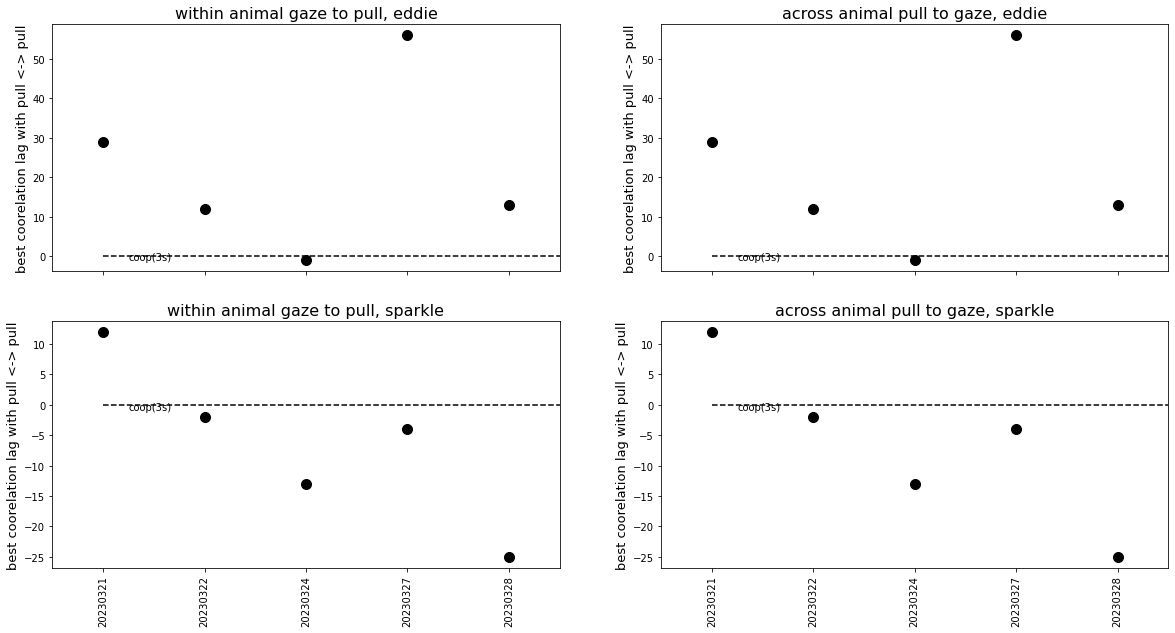

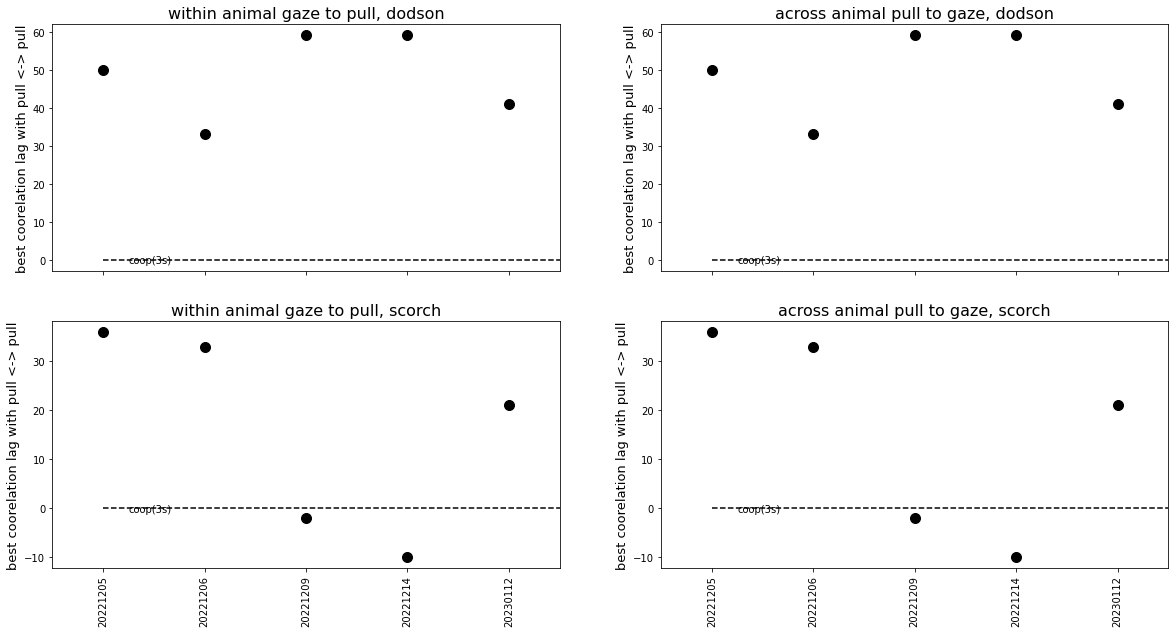

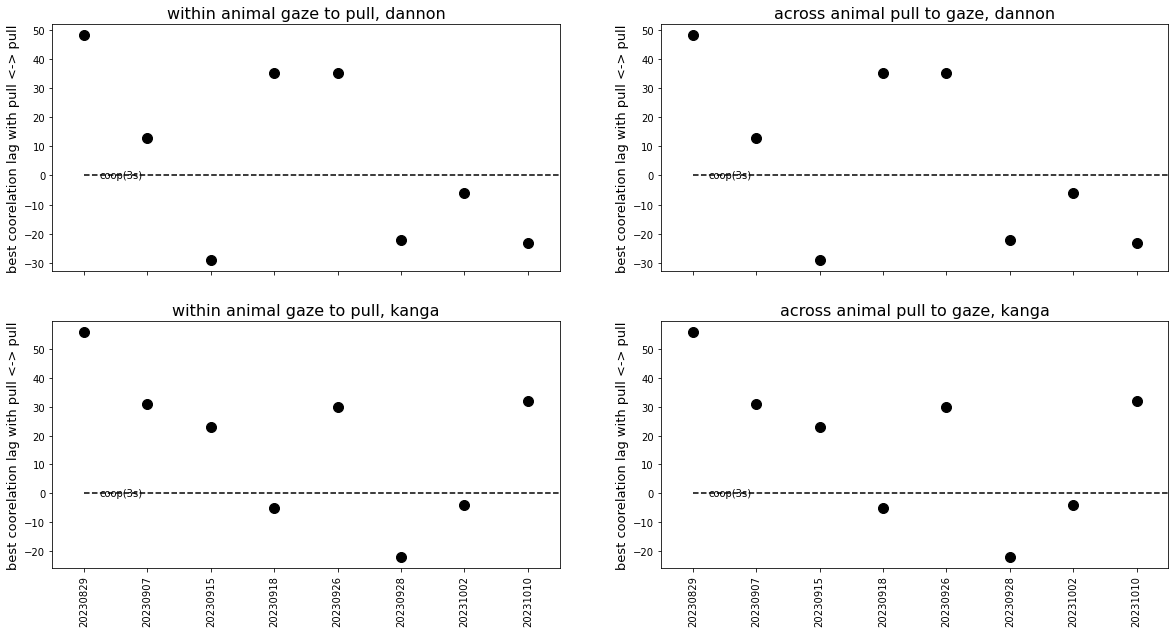

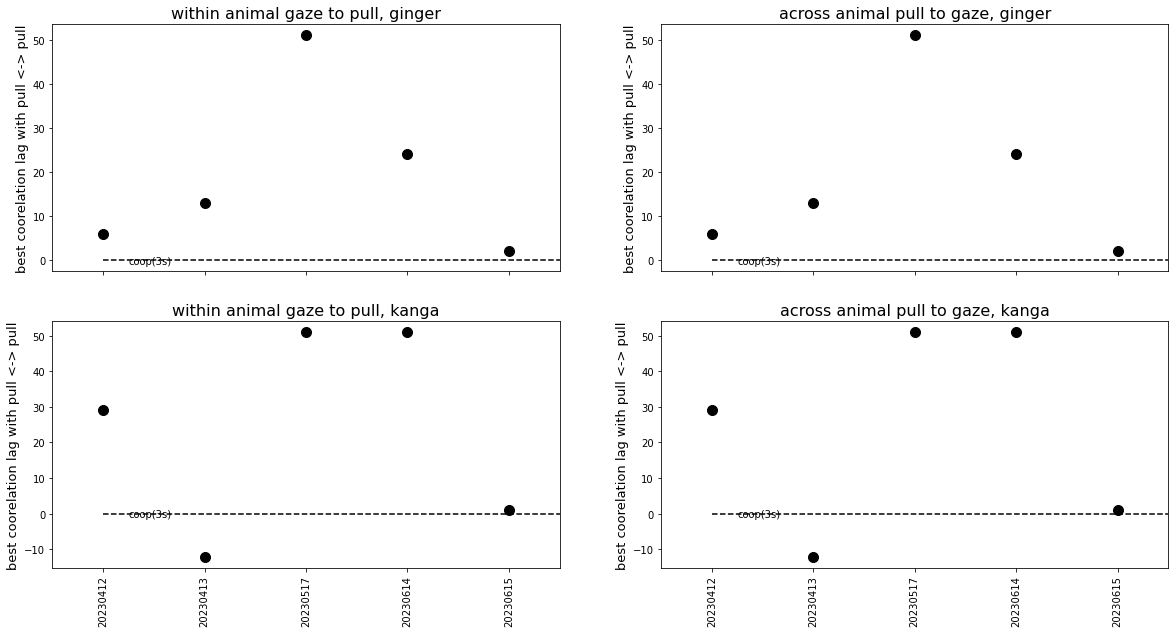

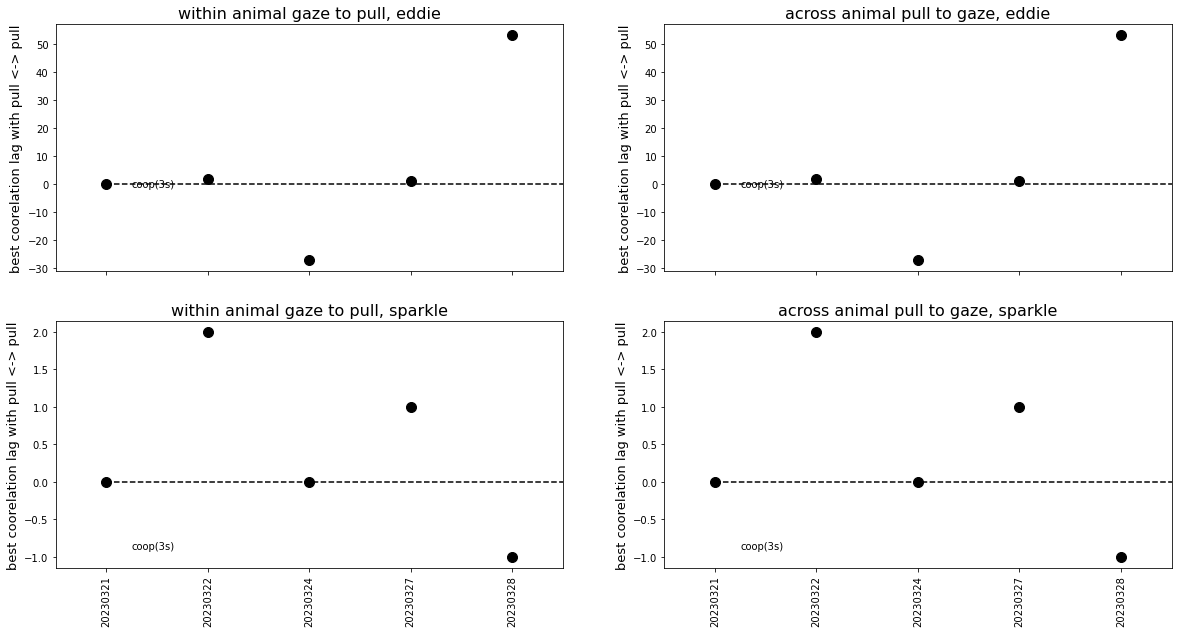

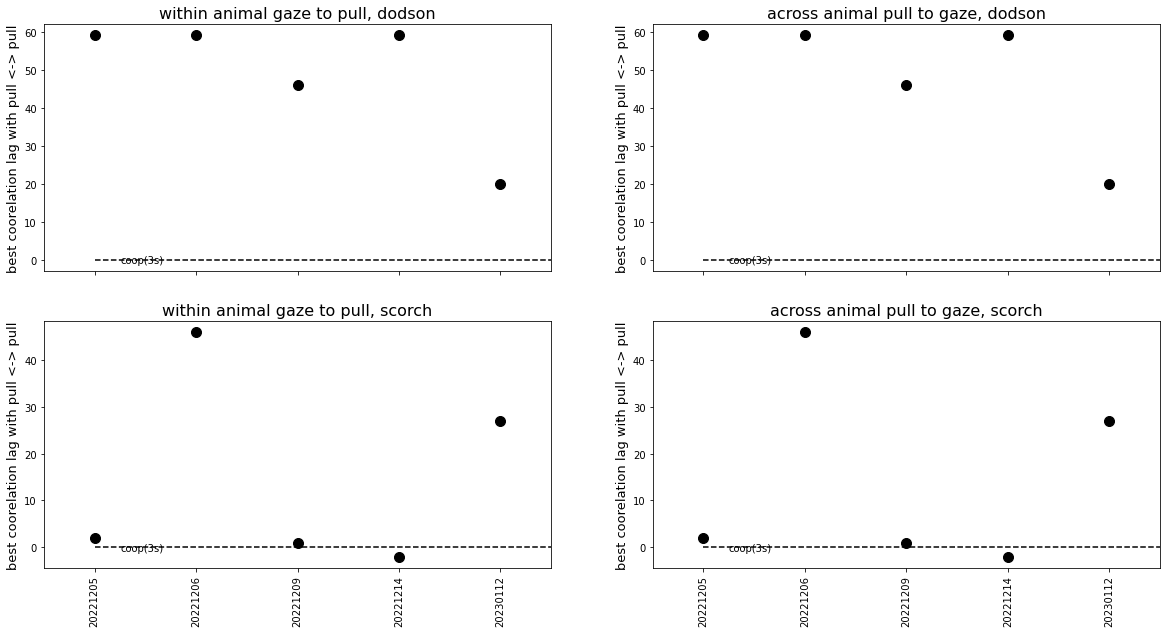

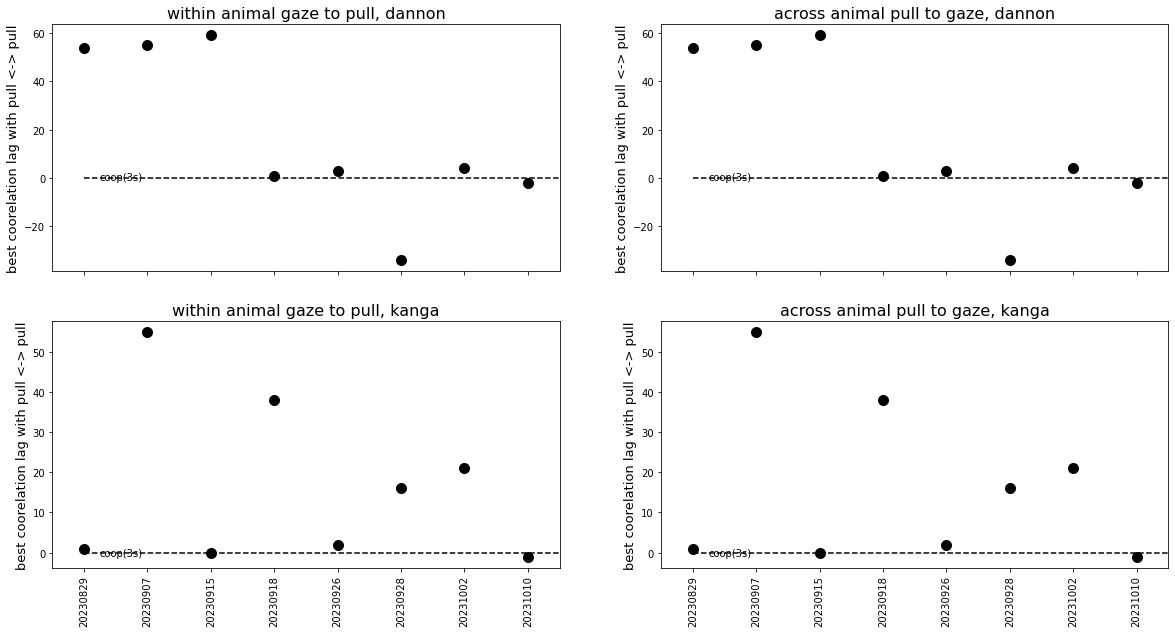

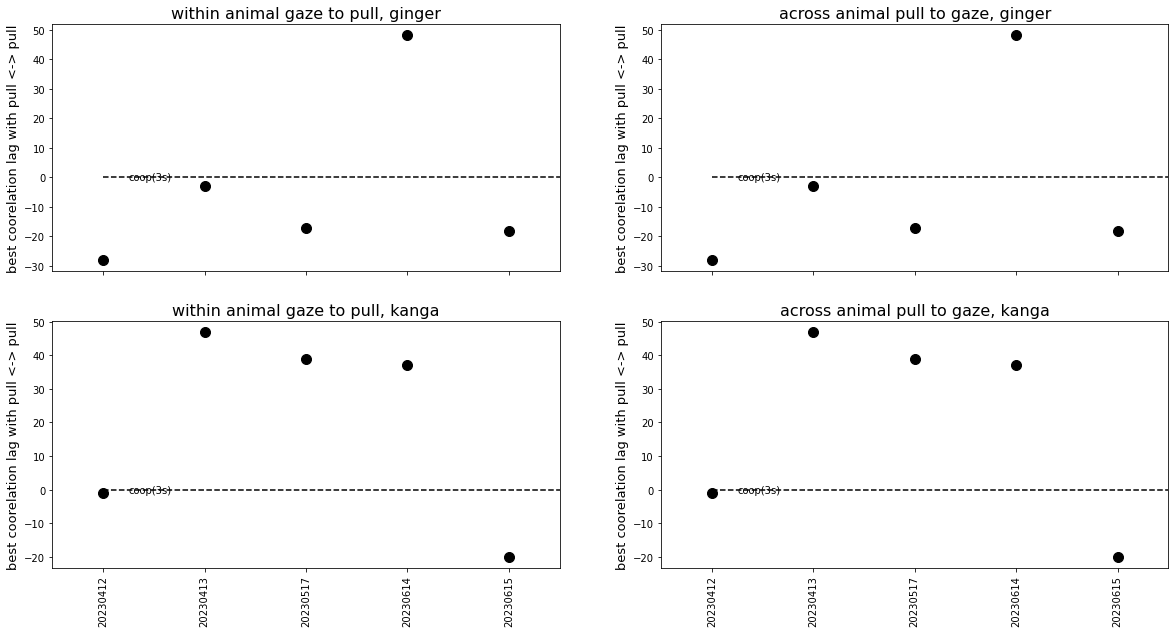

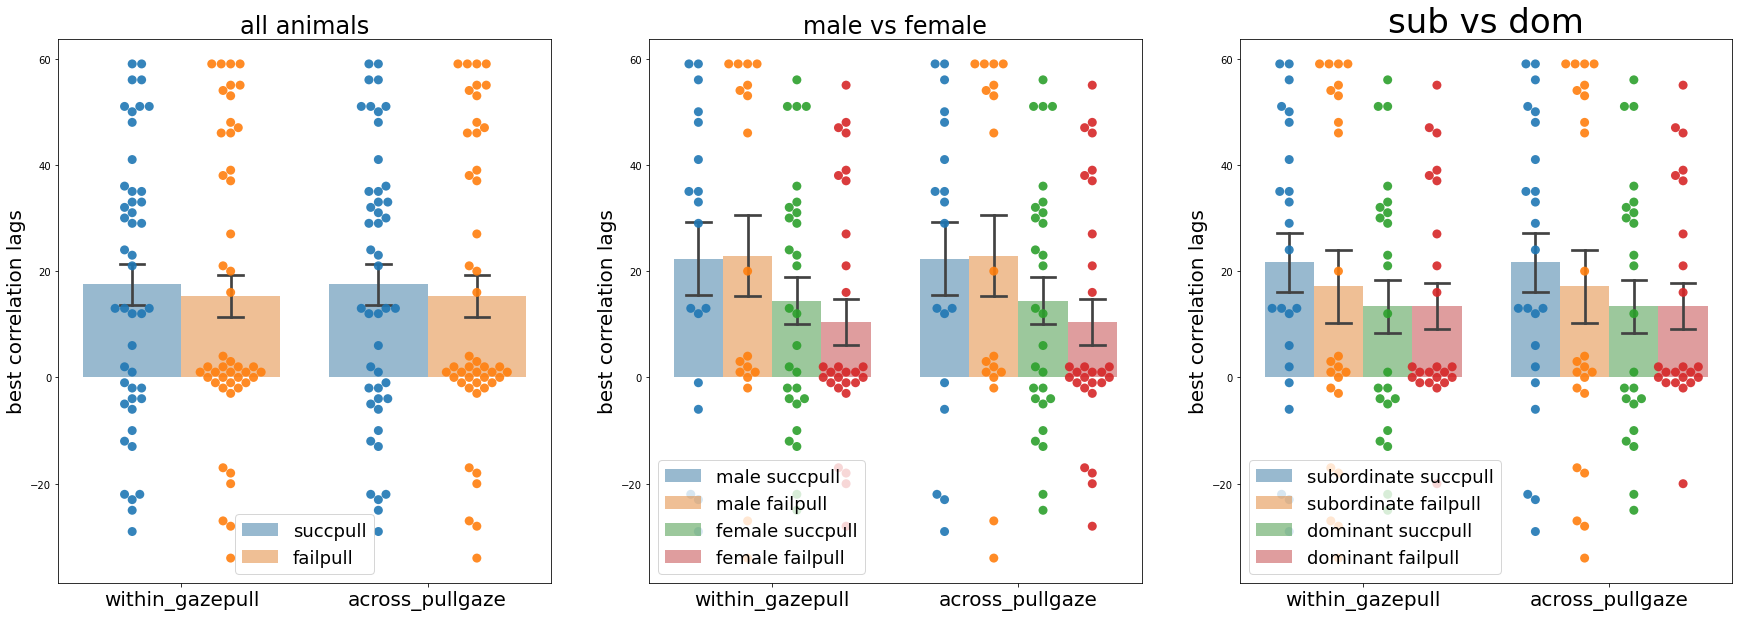

In [126]:
# PLOT multiple pairs in one plot, so need to load data seperately
mergetempRos = 0 # 1: merge different time bins
minmaxfullSampSize = 1 # 1: use the  min row number and max row number, or the full row for each session
moreSampSize = 0 # 1: use more sample size (more than just minimal row number and max row number)
#
animal1_fixedorders = ['eddie','dodson','dannon','ginger']
animal2_fixedorders = ['sparkle','scorch','kanga','kanga']
nanimalpairs = np.shape(animal1_fixedorders)[0]

temp_resolu = 1

succorfailpulls = ['succpull','failedpull']
nsuccorfail = np.shape(succorfailpulls)[0]

do_synedpulltime_pullgazetime = 0 # correlation between pairs of bhv events
do_pulltime_gazetime = 1 # plot the summarizing figure
#

# initiate the final data set
pull_gaze_time_bestlag_mean_all = dict.fromkeys(succorfailpulls,[])

across_pull_gaze_bestlag_allsessions_all = dict.fromkeys(succorfailpulls,[])
within_gaze_pull_bestlag_allsessions_all = dict.fromkeys(succorfailpulls,[])


for isuccorfail in np.arange(0,nsuccorfail,1):
    
    succorfailpull = succorfailpulls[isuccorfail]
    
    pull_gaze_time_bestlag_mean_all[succorfailpull] = np.zeros((nanimalpairs*2,2))
    

    for ianimalpair in np.arange(0,nanimalpairs,1):
        animal1_fixedorder = animal1_fixedorders[ianimalpair]
        animal2_fixedorder = animal2_fixedorders[ianimalpair]

        # load the basic behavioral measures
        # load saved data
        data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder+animal2_fixedorder+'/'
        #
        with open(data_saved_subfolder+'/owgaze1_num_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            owgaze1_num_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/owgaze2_num_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            owgaze2_num_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/mtgaze1_num_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            mtgaze1_num_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/mtgaze2_num_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            mtgaze2_num_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/pull1_num_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            pull1_num_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/pull2_num_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            pull2_num_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/tasktypes_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            tasktypes_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/coopthres_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            coopthres_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/succ_rate_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            succ_rate_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/interpullintv_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            interpullintv_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/trialnum_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            trialnum_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/bhv_intv_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            bhv_intv_all_dates = pickle.load(f)
        # 
        pullmean_num_all_dates = (pull1_num_all_dates+pull2_num_all_dates)/2
        #
        gaze1_num_all_dates = owgaze1_num_all_dates + mtgaze1_num_all_dates
        gaze2_num_all_dates = owgaze2_num_all_dates + mtgaze2_num_all_dates
        gazemean_num_all_dates = (gaze1_num_all_dates+gaze2_num_all_dates)/2

        # load the DBN related analysis
        # load data
        data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_allsessions'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder+animal2_fixedorder+'/'
        #
        if not mergetempRos:
            with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder+animal2_fixedorder+'_'+str(temp_resolu)+'sReSo.pkl', 'rb') as f:
                DBN_input_data_alltypes = pickle.load(f)
        else:
            with open(data_saved_subfolder+'//DBN_input_data_alltypes_'+animal1_fixedorder+animal2_fixedorder+'_mergeTempsReSo.pkl', 'rb') as f:
                DBN_input_data_alltypes = pickle.load(f)
        #
        # load data for successful and failed pulls
        data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_SuccAndFailedPull_allsessions'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder+animal2_fixedorder+'/'
        if not mergetempRos:
            with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder+animal2_fixedorder+'_'+str(temp_resolu)+'sReSo.pkl', 'rb') as f:
                DBN_input_data_alltypes_succfail = pickle.load(f)
        else:
            with open(data_saved_subfolder+'//DBN_input_data_alltypes_'+animal1_fixedorder+animal2_fixedorder+'_mergeTempsReSo.pkl', 'rb') as f:
                DBN_input_data_alltypes_succfail = pickle.load(f)

        #
        # re-organize the target dates
        # 100: self; 3: 3s coop; 2: 2s coop; 1.5: 1.5s coop; 1: 1s coop; -1: no-vision
        tasktypes_all_dates[tasktypes_all_dates==5] = -1 # change the task type code for no-vision
        coopthres_forsort = (tasktypes_all_dates-1)*coopthres_all_dates/2
        coopthres_forsort[coopthres_forsort==0] = 100 # get the cooperation threshold for sorting

        # temporily: for dannon/kanga, because some days were not analyzed for DBN
        if animal1_fixedorder == 'dannon':
            tasktypes_all_dates = tasktypes_all_dates[0:13]
            coopthres_forsort = coopthres_forsort[0:13]

        #
        # sort the data based on task type and dates
        dates_list = list(DBN_input_data_alltypes.keys())
        sorting_df = pd.DataFrame({'dates': dates_list, 'coopthres': coopthres_forsort.ravel()}, columns=['dates', 'coopthres'])
        sorting_df = sorting_df.sort_values(by=['coopthres','dates'], ascending = [False, True])
        #
        # only select the targeted dates
        # sorting_tgt_df = sorting_df[(sorting_df['coopthres']==1)|(sorting_df['coopthres']==1.5)|(sorting_df['coopthres']==2)|(sorting_df['coopthres']==3)]
        sorting_tgt_df = sorting_df[(sorting_df['coopthres']==1)]
        # sorting_tgt_df = sorting_df
        dates_list_tgt = sorting_tgt_df['dates']
        dates_list_tgt = np.array(dates_list_tgt)
        #
        ndates_tgt = np.shape(dates_list_tgt)[0]

        #
        # initiate the final data set
        within_pull_gaze_time_bestlag_all_ipair = dict.fromkeys(dates_list_tgt,[])
        across_pull_gaze_time_bestlag_all_ipair = dict.fromkeys(dates_list_tgt,[])


        for idate in np.arange(0,ndates_tgt,1):
            idate_name = dates_list_tgt[idate]

            DBN_input_data_idate_succfail = DBN_input_data_alltypes_succfail[succorfailpull][idate_name]
            DBN_input_data_idate = DBN_input_data_alltypes[idate_name]
            #
            if do_pulltime_gazetime: # this is the best!
                kernel_size = 3
                bestlag_limit = 60 # a limit to find the best lag, e.g. 60 second
                # single behavioral events  
                # pull1_t0 and gaze1_t0
                # xxx1 = (np.array(DBN_input_data_idate_succfail['pull1_t0'])==1)*1
                xxx1 = ((np.array(DBN_input_data_idate_succfail['pull1_t0'])==1)|(np.array(DBN_input_data_idate_succfail['pull2_t0'])==1))*1
                xxx2 = (np.array(DBN_input_data_idate['owgaze1_t0'])==1)*1
                try:
                    xxx_plot = np.linspace(0, np.shape(xxx1)[0], np.shape(xxx1)[0])
                    xxx1 = np.where(xxx1==1)[0]
                    kde = KernelDensity(kernel="gaussian", bandwidth=kernel_size).fit(xxx1.reshape(-1, 1))
                    log_dens = kde.score_samples(xxx_plot.reshape(-1, 1))
                    xxx1 = np.exp(log_dens)
                    #
                    xxx_plot = np.linspace(0, np.shape(xxx2)[0], np.shape(xxx2)[0])
                    xxx2 = np.where(xxx2==1)[0]
                    kde = KernelDensity(kernel="gaussian", bandwidth=kernel_size).fit(xxx2.reshape(-1, 1))
                    log_dens = kde.score_samples(xxx_plot.reshape(-1, 1))
                    xxx2 = np.exp(log_dens)
                    #
                    _,_,bestlag1 = xcorr(xxx2,xxx1,bestlag_limit)
                    # _,_,bestlag1 = correlagram(xxx2,xxx1,bestlag_limit)
                except:
                    bestlag1 = np.nan          
                # pull2_t0 and gaze1_t0
                # xxx1 = (np.array(DBN_input_data_idate_succfail['pull2_t0'])==1)*1
                xxx1 = ((np.array(DBN_input_data_idate_succfail['pull1_t0'])==1)|(np.array(DBN_input_data_idate_succfail['pull2_t0'])==1))*1
                xxx2 = (np.array(DBN_input_data_idate['owgaze1_t0'])==1)*1
                try:
                    xxx_plot = np.linspace(0, np.shape(xxx1)[0], np.shape(xxx1)[0])
                    xxx1 = np.where(xxx1==1)[0]
                    kde = KernelDensity(kernel="gaussian", bandwidth=kernel_size).fit(xxx1.reshape(-1, 1))
                    log_dens = kde.score_samples(xxx_plot.reshape(-1, 1))
                    xxx1 = np.exp(log_dens)
                    #
                    xxx_plot = np.linspace(0, np.shape(xxx2)[0], np.shape(xxx2)[0])
                    xxx2 = np.where(xxx2==1)[0]
                    kde = KernelDensity(kernel="gaussian", bandwidth=kernel_size).fit(xxx2.reshape(-1, 1))
                    log_dens = kde.score_samples(xxx_plot.reshape(-1, 1))
                    xxx2 = np.exp(log_dens)
                    #
                    _,_,bestlag2 = xcorr(xxx2,xxx1,bestlag_limit)
                    # _,_,bestlag2 = correlagram(xxx2,xxx1,bestlag_limit)
                except:
                    bestlag2 = np.nan
                # pull2_t0 and gaze2_t0
                # xxx1 = (np.array(DBN_input_data_idate_succfail['pull2_t0'])==1)*1
                xxx1 = ((np.array(DBN_input_data_idate_succfail['pull1_t0'])==1)|(np.array(DBN_input_data_idate_succfail['pull2_t0'])==1))*1
                xxx2 = (np.array(DBN_input_data_idate['owgaze2_t0'])==1)*1
                try:
                    xxx_plot = np.linspace(0, np.shape(xxx1)[0], np.shape(xxx1)[0])
                    xxx1 = np.where(xxx1==1)[0]
                    kde = KernelDensity(kernel="gaussian", bandwidth=kernel_size).fit(xxx1.reshape(-1, 1))
                    log_dens = kde.score_samples(xxx_plot.reshape(-1, 1))
                    xxx1 = np.exp(log_dens)
                    #
                    xxx_plot = np.linspace(0, np.shape(xxx2)[0], np.shape(xxx2)[0])
                    xxx2 = np.where(xxx2==1)[0]
                    kde = KernelDensity(kernel="gaussian", bandwidth=kernel_size).fit(xxx2.reshape(-1, 1))
                    log_dens = kde.score_samples(xxx_plot.reshape(-1, 1))
                    xxx2 = np.exp(log_dens)
                    #
                    _,_,bestlag3 = xcorr(xxx2,xxx1,bestlag_limit)
                    # _,_,bestlag3 = correlagram(xxx2,xxx1,bestlag_limit)
                except:
                    bestlag3 = np.nan
                # pull1_t0 and gaze2_t0
                # xxx1 = (np.array(DBN_input_data_idate_succfail['pull1_t0'])==1)*1
                xxx1 = ((np.array(DBN_input_data_idate_succfail['pull1_t0'])==1)|(np.array(DBN_input_data_idate_succfail['pull2_t0'])==1))*1
                xxx2 = (np.array(DBN_input_data_idate['owgaze2_t0'])==1)*1
                try:
                    xxx_plot = np.linspace(0, np.shape(xxx1)[0], np.shape(xxx1)[0])
                    xxx1 = np.where(xxx1==1)[0]
                    kde = KernelDensity(kernel="gaussian", bandwidth=kernel_size).fit(xxx1.reshape(-1, 1))
                    log_dens = kde.score_samples(xxx_plot.reshape(-1, 1))
                    xxx1 = np.exp(log_dens)
                    #
                    xxx_plot = np.linspace(0, np.shape(xxx2)[0], np.shape(xxx2)[0])
                    xxx2 = np.where(xxx2==1)[0]
                    kde = KernelDensity(kernel="gaussian", bandwidth=kernel_size).fit(xxx2.reshape(-1, 1))
                    log_dens = kde.score_samples(xxx_plot.reshape(-1, 1))
                    xxx2 = np.exp(log_dens)
                    #
                    _,_,bestlag4 = xcorr(xxx2,xxx1,bestlag_limit)
                    # _,_,bestlag4 = correlagram(xxx2,xxx1,bestlag_limit)
                except:
                    bestlag4 = np.nan
            #
            if do_synedpulltime_pullgazetime:
                kernel_size = 10
                bestlag_limit = 60 # a limit to find the best lag, e.g. 60 second
                # paired behavioral events
                # pull1_t1 and gaze1_t0
                xxx1 = (np.array(DBN_input_data_idate_succfail['pull1_t1'])==1)*1
                xxx2 = ((np.array(DBN_input_data_idate['pull1_t1'])==1)&(np.array(DBN_input_data_idate['owgaze1_t0'])==1))*1
                #
                try:
                    xxx_plot = np.linspace(0, np.shape(xxx1)[0], np.shape(xxx1)[0])
                    xxx1 = np.where(xxx1==1)[0]
                    kde = KernelDensity(kernel="gaussian", bandwidth=kernel_size).fit(xxx1.reshape(-1, 1))
                    log_dens = kde.score_samples(xxx_plot.reshape(-1, 1))
                    xxx1 = np.exp(log_dens)
                    #
                    xxx_plot = np.linspace(0, np.shape(xxx2)[0], np.shape(xxx2)[0])
                    xxx2 = np.where(xxx2==1)[0]
                    kde = KernelDensity(kernel="gaussian", bandwidth=kernel_size).fit(xxx2.reshape(-1, 1))
                    log_dens = kde.score_samples(xxx_plot.reshape(-1, 1))
                    xxx2 = np.exp(log_dens)
                    #
                    _,_,bestlag1 = xcorr(xxx2,xxx1,bestlag_limit)
                except:
                    bestlag1 = np.nan          
                # pull2_t0 and gaze1_t1
                xxx1 = (np.array(DBN_input_data_idate_succfail['pull2_t0'])==1)*1
                xxx2 = ((np.array(DBN_input_data_idate['pull2_t0'])==1)&(np.array(DBN_input_data_idate['owgaze1_t1'])==1))*1
                try:
                    xxx_plot = np.linspace(0, np.shape(xxx1)[0], np.shape(xxx1)[0])
                    xxx1 = np.where(xxx1==1)[0]
                    kde = KernelDensity(kernel="gaussian", bandwidth=kernel_size).fit(xxx1.reshape(-1, 1))
                    log_dens = kde.score_samples(xxx_plot.reshape(-1, 1))
                    xxx1 = np.exp(log_dens)
                    #
                    xxx_plot = np.linspace(0, np.shape(xxx2)[0], np.shape(xxx2)[0])
                    xxx2 = np.where(xxx2==1)[0]
                    kde = KernelDensity(kernel="gaussian", bandwidth=kernel_size).fit(xxx2.reshape(-1, 1))
                    log_dens = kde.score_samples(xxx_plot.reshape(-1, 1))
                    xxx2 = np.exp(log_dens)
                    #
                    _,_,bestlag2 = xcorr(xxx2,xxx,bestlag_limit1)
                except:
                    bestlag2 = np.nan
                # pull2_t1 and gaze2_t0
                xxx1 = (np.array(DBN_input_data_idate_succfail['pull2_t1'])==1)*1
                xxx2 = ((np.array(DBN_input_data_idate['pull2_t1'])==1)&(np.array(DBN_input_data_idate['owgaze2_t0'])==1))*1
                try:
                    xxx_plot = np.linspace(0, np.shape(xxx1)[0], np.shape(xxx1)[0])
                    xxx1 = np.where(xxx1==1)[0]
                    kde = KernelDensity(kernel="gaussian", bandwidth=kernel_size).fit(xxx1.reshape(-1, 1))
                    log_dens = kde.score_samples(xxx_plot.reshape(-1, 1))
                    xxx1 = np.exp(log_dens)
                    #
                    xxx_plot = np.linspace(0, np.shape(xxx2)[0], np.shape(xxx2)[0])
                    xxx2 = np.where(xxx2==1)[0]
                    kde = KernelDensity(kernel="gaussian", bandwidth=kernel_size).fit(xxx2.reshape(-1, 1))
                    log_dens = kde.score_samples(xxx_plot.reshape(-1, 1))
                    xxx2 = np.exp(log_dens)
                    #
                    _,_,bestlag3 = xcorr(xxx2,xxx1,bestlag_limit)
                except:
                    bestlag3 = np.nan
                # pull1_t0 and gaze2_t1
                xxx1 = (np.array(DBN_input_data_idate_succfail['pull1_t0'])==1)*1
                xxx2 = ((np.array(DBN_input_data_idate['pull1_t0'])==1)&(np.array(DBN_input_data_idate['owgaze2_t1'])==1))*1
                try:
                    xxx_plot = np.linspace(0, np.shape(xxx1)[0], np.shape(xxx1)[0])
                    xxx1 = np.where(xxx1==1)[0]
                    kde = KernelDensity(kernel="gaussian", bandwidth=kernel_size).fit(xxx1.reshape(-1, 1))
                    log_dens = kde.score_samples(xxx_plot.reshape(-1, 1))
                    xxx1 = np.exp(log_dens)
                    #
                    xxx_plot = np.linspace(0, np.shape(xxx2)[0], np.shape(xxx2)[0])
                    xxx2 = np.where(xxx2==1)[0]
                    kde = KernelDensity(kernel="gaussian", bandwidth=kernel_size).fit(xxx2.reshape(-1, 1))
                    log_dens = kde.score_samples(xxx_plot.reshape(-1, 1))
                    xxx2 = np.exp(log_dens)
                    #
                    _,_,bestlag4 = xcorr(xxx2,xxx1,bestlag_limit)
                except:
                    bestlag4 = np.nan


            #    
            within_pull_gaze_time_bestlag_all_ipair[idate_name] = [bestlag1,bestlag3]
            across_pull_gaze_time_bestlag_all_ipair[idate_name] = [bestlag2,bestlag4]


        # organize the data to the summarizing mean variables
        pull_gaze_time_bestlag_mean_all[succorfailpull][[ianimalpair*2,ianimalpair*2+1],0]=np.nanmean(pd.DataFrame(within_pull_gaze_time_bestlag_all_ipair),axis=1)
        pull_gaze_time_bestlag_mean_all[succorfailpull][[ianimalpair*2,ianimalpair*2+1],1]=np.nanmean(pd.DataFrame(across_pull_gaze_time_bestlag_all_ipair),axis=1)

        # organize the data to the summarizing all session variables 
        df = pd.DataFrame(within_pull_gaze_time_bestlag_all_ipair).T
        df.reset_index(drop=True, inplace=True)
        if ianimalpair == 0:
            within_gaze_pull_bestlag_allsessions_all[succorfailpull]=df
        else:
            within_gaze_pull_bestlag_allsessions_all[succorfailpull] = pd.concat([within_gaze_pull_bestlag_allsessions_all[succorfailpull],df],axis = 1)
        #    
        df = pd.DataFrame(across_pull_gaze_time_bestlag_all_ipair).T
        df.reset_index(drop=True, inplace=True)
        if ianimalpair == 0:
            across_pull_gaze_bestlag_allsessions_all[succorfailpull]=df
        else:
            across_pull_gaze_bestlag_allsessions_all[succorfailpull] = pd.concat([across_pull_gaze_bestlag_allsessions_all[succorfailpull],df],axis = 1)
        

        # plot each animal pair first
        # figure initiate
        fig, axs = plt.subplots(2,2)
        fig.set_figheight(5*2)
        fig.set_figwidth(10*2)
        #
        plottype_names = ['within animal gaze to pull, '+animal1_fixedorder,
                          'across animal pull to gaze, '+animal1_fixedorder,
                          'within animal gaze to pull, '+animal2_fixedorder,
                          'across animal pull to gaze, '+animal2_fixedorder]
        plotbestlags_pooled = [
                            np.array(pd.DataFrame(within_pull_gaze_time_bestlag_all_ipair).T)[:,0],
                            np.array(pd.DataFrame(across_pull_gaze_time_bestlag_all_ipair).T)[:,0],
                            np.array(pd.DataFrame(within_pull_gaze_time_bestlag_all_ipair).T)[:,1],
                            np.array(pd.DataFrame(across_pull_gaze_time_bestlag_all_ipair).T)[:,1],
                           ]
        #
        for iplot in np.arange(0,4,1):
            #
            plottype_name = plottype_names[iplot]
            plotbestlags = plotbestlags_pooled[iplot]

            # plot 
            axs.flatten()[iplot].plot(np.arange(0,ndates_tgt,1),plotbestlags,'ko',markersize=10)
            #
            axs.flatten()[iplot].set_title(plottype_name,fontsize=16)
            axs.flatten()[iplot].set_ylabel('best coorelation lag with pull <-> pull',fontsize=13)
            #axs.flatten()[iplot].set_ylim([-1.1,1.1])
            axs.flatten()[iplot].set_xlim([-0.5,ndates_tgt-0.5])
            #
            if iplot > 1:
                axs.flatten()[iplot].set_xticks(np.arange(0,ndates_tgt,1))
                axs.flatten()[iplot].set_xticklabels(dates_list_tgt, rotation=90,fontsize=10)
            else:
                axs.flatten()[iplot].set_xticklabels('')
            #
            # tasktypes = ['self','coop(3s)','coop(2s)','coop(1.5s)','coop(1s)','no-vision']
            tasktypes = ['coop(3s)','coop(2s)','coop(1.5s)','coop(1s)']
            taskswitches = np.where(np.array(sorting_tgt_df['coopthres'])[1:]-np.array(sorting_tgt_df['coopthres'])[:-1]!=0)[0]+0.5
            for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
                taskswitch = taskswitches[itaskswitch]
                axs.flatten()[iplot].plot([taskswitch,taskswitch],[-1.1,1.1],'k--')
            taskswitches = np.concatenate(([0],taskswitches))
            for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
                taskswitch = taskswitches[itaskswitch]
                axs.flatten()[iplot].text(taskswitch+0.25,-0.9,tasktypes[itaskswitch],fontsize=10)
            axs.flatten()[iplot].plot([0,ndates_tgt],[0,0],'k--')

        savefigs = 0
        if savefigs:
            figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_SuccAndFailedPull_singlecam_wholebodylabels_allsessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder+animal2_fixedorder+'/'       
            if not os.path.exists(figsavefolder):
                os.makedirs(figsavefolder)
            plt.savefig(figsavefolder+succorfailpull+'_pulltime_gazetime_bestCorrlag_'+animal1_fixedorder+animal2_fixedorder+'.pdf')

    
    
    
# plot the summarizing figure
#
fig, axs = plt.subplots(1,3)
fig.set_figheight(10)
fig.set_figwidth(10*3)

dependencytargets = ['within_gazepull','across_pullgaze']
# dependencytargets = dependencynames

# plot 1
# average all animals for each dependency, separate successful and failed pull
# pull_gaze_time_bestlag_tgt_succpull = pull_gaze_time_bestlag_mean_all['succpull']
# pull_gaze_time_bestlag_tgt_failpull = pull_gaze_time_bestlag_mean_all['failedpull']
ay1 = within_gaze_pull_bestlag_allsessions_all['failedpull'].values.flatten()
ay2 = across_pull_gaze_bestlag_allsessions_all['failedpull'].values.flatten()
pull_gaze_time_bestlag_tgt_failpull = np.array([ay1,ay2]).T
ay1 = within_gaze_pull_bestlag_allsessions_all['succpull'].values.flatten()
ay2 = across_pull_gaze_bestlag_allsessions_all['succpull'].values.flatten()
pull_gaze_time_bestlag_tgt_succpull = np.array([ay1,ay2]).T
measure_tgt_name = 'best correlation lags' 
# 
pull_gaze_time_bestlag_tgt_succpull_df = pd.DataFrame(pull_gaze_time_bestlag_tgt_succpull)
pull_gaze_time_bestlag_tgt_succpull_df.columns = dependencytargets
pull_gaze_time_bestlag_tgt_succpull_df['type'] = 'succpull'
#
pull_gaze_time_bestlag_tgt_failpull_df = pd.DataFrame(pull_gaze_time_bestlag_tgt_failpull)
pull_gaze_time_bestlag_tgt_failpull_df.columns = dependencytargets
pull_gaze_time_bestlag_tgt_failpull_df['type'] = 'failpull'
#
df_long=pd.concat([pull_gaze_time_bestlag_tgt_succpull_df,pull_gaze_time_bestlag_tgt_failpull_df])
df_long2 = df_long.melt(id_vars=['type'], value_vars=dependencytargets,var_name='condition', value_name='value')
# barplot ans swarmplot
seaborn.barplot(ax=axs.ravel()[0],data=df_long2,x='condition',y='value',hue='type',errorbar='se',alpha=.5,capsize=0.1)
seaborn.swarmplot(ax=axs.ravel()[0],data=df_long2,x='condition',y='value',hue='type',alpha=.9,size= 9,dodge=True,legend=False)
axs.ravel()[0].set_xlabel('')
axs.ravel()[0].xaxis.set_tick_params(labelsize=20)
axs.ravel()[0].set_ylabel(measure_tgt_name,fontsize=20)
axs.ravel()[0].set_title('all animals' ,fontsize=24)
# axs.ravel()[0].set_ylim([-2.35,2.35])
# axs.ravel()[0].set_ylim([-1,1])
axs.ravel()[0].legend(fontsize=18)

# plot 2
# separating male and female
ay1 = within_gaze_pull_bestlag_allsessions_all['succpull'].T.iloc[[0,2,4]].T.values.flatten()
ay2 = across_pull_gaze_bestlag_allsessions_all['succpull'].T.iloc[[0,2,4]].T.values.flatten()
pull_gaze_time_bestlag_tgt_male_succpull = np.array([ay1,ay2]).T
pull_gaze_time_bestlag_tgt_male_succpull_df = pd.DataFrame(pull_gaze_time_bestlag_tgt_male_succpull)
#pull_gaze_time_bestlag_tgt_male_succpull_df = pd.DataFrame(pull_gaze_time_bestlag_tgt_succpull[[0,2,4],:])
pull_gaze_time_bestlag_tgt_male_succpull_df.columns = dependencytargets
pull_gaze_time_bestlag_tgt_male_succpull_df['type'] = 'male succpull'
#
ay1 = within_gaze_pull_bestlag_allsessions_all['failedpull'].T.iloc[[0,2,4]].T.values.flatten()
ay2 = across_pull_gaze_bestlag_allsessions_all['failedpull'].T.iloc[[0,2,4]].T.values.flatten()
pull_gaze_time_bestlag_tgt_male_failpull = np.array([ay1,ay2]).T
pull_gaze_time_bestlag_tgt_male_failpull_df = pd.DataFrame(pull_gaze_time_bestlag_tgt_male_failpull)
#pull_gaze_time_bestlag_tgt_male_failpull_df = pd.DataFrame(pull_gaze_time_bestlag_tgt_failpull[[0,2,4],:])
pull_gaze_time_bestlag_tgt_male_failpull_df.columns = dependencytargets
pull_gaze_time_bestlag_tgt_male_failpull_df['type'] = 'male failpull'
#
ay1 = within_gaze_pull_bestlag_allsessions_all['succpull'].T.iloc[[1,3,5,6,7]].T.values.flatten()
ay2 = across_pull_gaze_bestlag_allsessions_all['succpull'].T.iloc[[1,3,5,6,7]].T.values.flatten()
pull_gaze_time_bestlag_tgt_female_succpull = np.array([ay1,ay2]).T
pull_gaze_time_bestlag_tgt_female_succpull_df = pd.DataFrame(pull_gaze_time_bestlag_tgt_female_succpull)
#pull_gaze_time_bestlag_tgt_female_succpull_df = pd.DataFrame(pull_gaze_time_bestlag_tgt_succpull[[1,3,5,6,7],:])
pull_gaze_time_bestlag_tgt_female_succpull_df.columns = dependencytargets
pull_gaze_time_bestlag_tgt_female_succpull_df['type'] = 'female succpull'
#
ay1 = within_gaze_pull_bestlag_allsessions_all['failedpull'].T.iloc[[1,3,5,6,7]].T.values.flatten()
ay2 = across_pull_gaze_bestlag_allsessions_all['failedpull'].T.iloc[[1,3,5,6,7]].T.values.flatten()
pull_gaze_time_bestlag_tgt_female_failpull = np.array([ay1,ay2]).T
pull_gaze_time_bestlag_tgt_female_failpull_df = pd.DataFrame(pull_gaze_time_bestlag_tgt_female_failpull)
#pull_gaze_time_bestlag_tgt_female_failpull_df = pd.DataFrame(pull_gaze_time_bestlag_tgt_failpull[[1,3,5,6,7],:])
pull_gaze_time_bestlag_tgt_female_failpull_df.columns = dependencytargets
pull_gaze_time_bestlag_tgt_female_failpull_df['type'] = 'female failpull'

    
    
#
df_long=pd.concat([pull_gaze_time_bestlag_tgt_male_succpull_df,pull_gaze_time_bestlag_tgt_male_failpull_df,
                   pull_gaze_time_bestlag_tgt_female_succpull_df,pull_gaze_time_bestlag_tgt_female_failpull_df,])
df_long2 = df_long.melt(id_vars=['type'], value_vars=dependencytargets,var_name='condition', value_name='value')
# barplot ans swarmplot
seaborn.barplot(ax=axs.ravel()[1],data=df_long2,x='condition',y='value',hue='type',errorbar='se',alpha=.5,capsize=0.1)
seaborn.swarmplot(ax=axs.ravel()[1],data=df_long2,x='condition',y='value',hue='type',alpha=.9,size= 9,dodge=True,legend=False)
axs.ravel()[1].set_xlabel('')
axs.ravel()[1].xaxis.set_tick_params(labelsize=20)
axs.ravel()[1].set_ylabel(measure_tgt_name,fontsize=20)
axs.ravel()[1].set_title('male vs female' ,fontsize=24)
# axs.ravel()[1].set_ylim([-2.35,2.35])
# axs.ravel()[1].set_ylim([-1,1])
axs.ravel()[1].legend(fontsize=18)

# plot 3
# separating subordinate and dominant
ay1 = within_gaze_pull_bestlag_allsessions_all['succpull'].T.iloc[[0,2,4,6]].T.values.flatten()
ay2 = across_pull_gaze_bestlag_allsessions_all['succpull'].T.iloc[[0,2,4,6]].T.values.flatten()
pull_gaze_time_bestlag_tgt_sub_succpull = np.array([ay1,ay2]).T
pull_gaze_time_bestlag_tgt_sub_succpull_df = pd.DataFrame(pull_gaze_time_bestlag_tgt_sub_succpull)
#pull_gaze_time_bestlag_tgt_sub_succpull_df = pd.DataFrame(pull_gaze_time_bestlag_tgt_succpull[[0,2,4,6],:])
pull_gaze_time_bestlag_tgt_sub_succpull_df.columns = dependencytargets
pull_gaze_time_bestlag_tgt_sub_succpull_df['type'] = 'subordinate succpull'
#
ay1 = within_gaze_pull_bestlag_allsessions_all['failedpull'].T.iloc[[0,2,4,6]].T.values.flatten()
ay2 = across_pull_gaze_bestlag_allsessions_all['failedpull'].T.iloc[[0,2,4,6]].T.values.flatten()
pull_gaze_time_bestlag_tgt_sub_failpull = np.array([ay1,ay2]).T
pull_gaze_time_bestlag_tgt_sub_failpull_df = pd.DataFrame(pull_gaze_time_bestlag_tgt_sub_failpull)
#pull_gaze_time_bestlag_tgt_sub_failpull_df = pd.DataFrame(pull_gaze_time_bestlag_tgt_failpull[[0,2,4,6],:])
pull_gaze_time_bestlag_tgt_sub_failpull_df.columns = dependencytargets
pull_gaze_time_bestlag_tgt_sub_failpull_df['type'] = 'subordinate failpull'
#
ay1 = within_gaze_pull_bestlag_allsessions_all['succpull'].T.iloc[[1,3,5,7]].T.values.flatten()
ay2 = across_pull_gaze_bestlag_allsessions_all['succpull'].T.iloc[[1,3,5,7]].T.values.flatten()
pull_gaze_time_bestlag_tgt_dom_succpull = np.array([ay1,ay2]).T
pull_gaze_time_bestlag_tgt_dom_succpull_df = pd.DataFrame(pull_gaze_time_bestlag_tgt_dom_succpull)
#pull_gaze_time_bestlag_tgt_dom_succpull_df = pd.DataFrame(pull_gaze_time_bestlag_tgt_succpull[[1,3,5,7],:])
pull_gaze_time_bestlag_tgt_dom_succpull_df.columns = dependencytargets
pull_gaze_time_bestlag_tgt_dom_succpull_df['type'] = 'dominant succpull'
#
ay1 = within_gaze_pull_bestlag_allsessions_all['failedpull'].T.iloc[[1,3,5,7]].T.values.flatten()
ay2 = across_pull_gaze_bestlag_allsessions_all['failedpull'].T.iloc[[1,3,5,7]].T.values.flatten()
pull_gaze_time_bestlag_tgt_dom_failpull = np.array([ay1,ay2]).T
pull_gaze_time_bestlag_tgt_dom_failpull_df = pd.DataFrame(pull_gaze_time_bestlag_tgt_dom_failpull)
# pull_gaze_time_bestlag_tgt_dom_failpull_df = pd.DataFrame(pull_gaze_time_bestlag_tgt_failpull[[1,3,5,7],:])
pull_gaze_time_bestlag_tgt_dom_failpull_df.columns = dependencytargets
pull_gaze_time_bestlag_tgt_dom_failpull_df['type'] = 'dominant failpull'
#
df_long=pd.concat([pull_gaze_time_bestlag_tgt_sub_succpull_df,pull_gaze_time_bestlag_tgt_sub_failpull_df,
                   pull_gaze_time_bestlag_tgt_dom_succpull_df,pull_gaze_time_bestlag_tgt_dom_failpull_df])
df_long2 = df_long.melt(id_vars=['type'], value_vars=dependencytargets,var_name='condition', value_name='value')
# barplot ans swarmplot
seaborn.barplot(ax=axs.ravel()[2],data=df_long2,x='condition',y='value',hue='type',errorbar='se',alpha=.5,capsize=0.1)
seaborn.swarmplot(ax=axs.ravel()[2],data=df_long2,x='condition',y='value',hue='type',alpha=.9,size= 9,dodge=True,legend=False)
axs.ravel()[2].set_xlabel('')
axs.ravel()[2].xaxis.set_tick_params(labelsize=20)
axs.ravel()[2].set_ylabel(measure_tgt_name,fontsize=20)
axs.ravel()[2].set_title('sub vs dom' ,fontsize=34)
# axs.ravel()[2].set_ylim([-2.35,2.35])
# axs.ravel()[2].set_ylim([-1,1])
axs.ravel()[2].legend(fontsize=18)


savefigs = 0
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_SuccAndFailedPull_singlecam_wholebodylabels_allsessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    if  do_synedpulltime_pullgazetime:
        plt.savefig(figsavefolder+"succorfailpulls_syncedpulltime_pullgazetime_bestcorrlag_summaryplot.pdf")
    elif do_pulltime_gazetime:       
        plt.savefig(figsavefolder+"succorfailpulls_pulltime_gazetime_bestcorrlag_summaryplot.pdf")


##### one example session

corr between animal 1 succ and failed pulls: -0.4119978428535965
corr between animal 1 succ pulls and animal 1 social gaze: -0.05401929308803929
corr between animal 1 failed pulls and animal 1 socal gaze: 0.5133189446455041
corr between animal 2 succ and failed pulls: -0.638605794913308
corr between animal 2 succ pulls and animal 2 social gaze: -0.16232283764234356
corr between animal 2 failed pulls and animal 2 socal gaze: 0.607255741458924


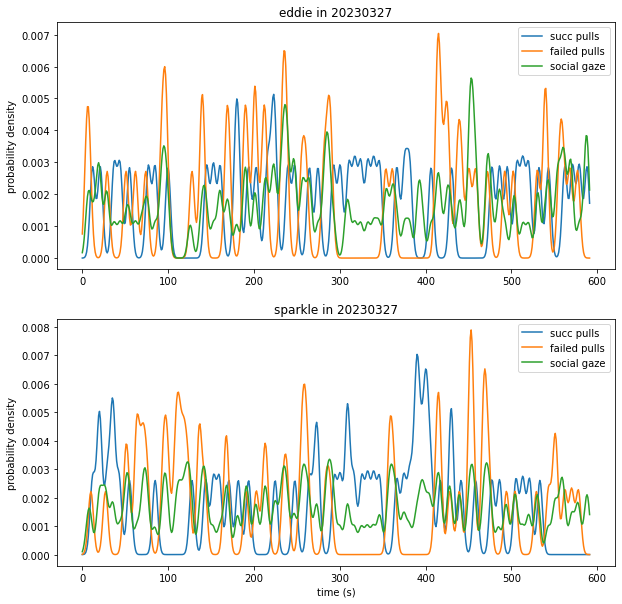

In [252]:
animal1_fixedorder = 'eddie'
animal2_fixedorder = 'sparkle'
idate_name = '20230327'

kernel_width = 3

# load the DBN related analysis
# load data
data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_allsessions'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder+animal2_fixedorder+'/'
#
if not mergetempRos:
    with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder+animal2_fixedorder+'_'+str(temp_resolu)+'sReSo.pkl', 'rb') as f:
        DBN_input_data_alltypes = pickle.load(f)
else:
    with open(data_saved_subfolder+'//DBN_input_data_alltypes_'+animal1_fixedorder+animal2_fixedorder+'_mergeTempsReSo.pkl', 'rb') as f:
        DBN_input_data_alltypes = pickle.load(f)
#
# load data for successful and failed pulls
data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_SuccAndFailedPull_allsessions'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder+animal2_fixedorder+'/'
if not mergetempRos:
    with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder+animal2_fixedorder+'_'+str(temp_resolu)+'sReSo.pkl', 'rb') as f:
        DBN_input_data_alltypes_succfail = pickle.load(f)
else:
    with open(data_saved_subfolder+'//DBN_input_data_alltypes_'+animal1_fixedorder+animal2_fixedorder+'_mergeTempsReSo.pkl', 'rb') as f:
        DBN_input_data_alltypes_succfail = pickle.load(f)

DBN_input_data_idate_succ = DBN_input_data_alltypes_succfail['succpull'][idate_name]
DBN_input_data_idate_fail = DBN_input_data_alltypes_succfail['failedpull'][idate_name]
DBN_input_data_idate = DBN_input_data_alltypes[idate_name]

#
fig, axs = plt.subplots(2,1)
fig.set_figheight(2*5)
fig.set_figwidth(1*10)

#####
# animal 1 gaze

xxx1 = (np.array(DBN_input_data_idate_succ['pull1_t0'])==1)*1
#
xxx_plot = np.linspace(0, np.shape(xxx1)[0], np.shape(xxx1)[0])
xxx1 = np.where(xxx1==1)[0]
kde = KernelDensity(kernel="gaussian", bandwidth=kernel_width).fit(xxx1.reshape(-1, 1))
log_dens = kde.score_samples(xxx_plot.reshape(-1, 1))
xxx1 = np.exp(log_dens)
                
xxx2 = (np.array(DBN_input_data_idate_fail['pull1_t0'])==1)*1
#
xxx_plot = np.linspace(0, np.shape(xxx2)[0], np.shape(xxx2)[0])
xxx2 = np.where(xxx2==1)[0]
kde = KernelDensity(kernel="gaussian", bandwidth=kernel_width).fit(xxx2.reshape(-1, 1))
log_dens = kde.score_samples(xxx_plot.reshape(-1, 1))
xxx2 = np.exp(log_dens)

xxx3 = (np.array(DBN_input_data_idate['owgaze1_t0'])==1)*1
#
xxx_plot = np.linspace(0, np.shape(xxx3)[0], np.shape(xxx3)[0])
xxx3 = np.where(xxx3==1)[0]
kde = KernelDensity(kernel="gaussian", bandwidth=kernel_width).fit(xxx3.reshape(-1, 1))
log_dens = kde.score_samples(xxx_plot.reshape(-1, 1))
xxx3 = np.exp(log_dens)

#
axs[0].plot(xxx1)
axs[0].plot(xxx2)
axs[0].plot(xxx3)
axs[0].set_title(animal1_fixedorder + ' in '+idate_name)
axs[0].legend(['succ pulls','failed pulls','social gaze'])
axs[0].set_ylabel('probability density')

rr,pp = scipy.stats.spearmanr(xxx1, xxx2)
print('corr between animal 1 succ and failed pulls: '+str(rr))
#
rr,pp = scipy.stats.spearmanr(xxx1, xxx3)
print('corr between animal 1 succ pulls and animal 1 social gaze: '+str(rr))
#
rr,pp = scipy.stats.spearmanr(xxx2, xxx3)
print('corr between animal 1 failed pulls and animal 1 socal gaze: '+str(rr))


#####
# animal 2 gaze

xxx1 = (np.array(DBN_input_data_idate_succ['pull2_t0'])==1)*1
#
xxx_plot = np.linspace(0, np.shape(xxx1)[0], np.shape(xxx1)[0])
xxx1 = np.where(xxx1==1)[0]
kde = KernelDensity(kernel="gaussian", bandwidth=kernel_width).fit(xxx1.reshape(-1, 1))
log_dens = kde.score_samples(xxx_plot.reshape(-1, 1))
xxx1 = np.exp(log_dens)
                
xxx2 = (np.array(DBN_input_data_idate_fail['pull2_t0'])==1)*1
#
xxx_plot = np.linspace(0, np.shape(xxx2)[0], np.shape(xxx2)[0])
xxx2 = np.where(xxx2==1)[0]
kde = KernelDensity(kernel="gaussian", bandwidth=kernel_width).fit(xxx2.reshape(-1, 1))
log_dens = kde.score_samples(xxx_plot.reshape(-1, 1))
xxx2 = np.exp(log_dens)

xxx3 = (np.array(DBN_input_data_idate['owgaze2_t0'])==1)*1
#
xxx_plot = np.linspace(0, np.shape(xxx3)[0], np.shape(xxx3)[0])
xxx3 = np.where(xxx3==1)[0]
kde = KernelDensity(kernel="gaussian", bandwidth=kernel_width).fit(xxx3.reshape(-1, 1))
log_dens = kde.score_samples(xxx_plot.reshape(-1, 1))
xxx3 = np.exp(log_dens)

axs[1].plot(xxx1)
axs[1].plot(xxx2)
axs[1].plot(xxx3)
axs[1].set_title(animal2_fixedorder + ' in '+idate_name)
axs[1].legend(['succ pulls','failed pulls','social gaze'])
axs[1].set_ylabel('probability density')
axs[1].set_xlabel('time (s)')

rr,pp = scipy.stats.spearmanr(xxx1, xxx2)
print('corr between animal 2 succ and failed pulls: '+str(rr))
#
rr,pp = scipy.stats.spearmanr(xxx1, xxx3)
print('corr between animal 2 succ pulls and animal 2 social gaze: '+str(rr))
#
rr,pp = scipy.stats.spearmanr(xxx2, xxx3)
print('corr between animal 2 failed pulls and animal 2 socal gaze: '+str(rr))


In [63]:
xxx1 = (np.array(DBN_input_data_idate_succ['pull1_t0'])==1)*1
#
xxx_plot = np.linspace(0, np.shape(xxx1)[0], np.shape(xxx1)[0])
xxx1 = np.where(xxx1==1)[0]
kde = KernelDensity(kernel="gaussian", bandwidth=kernel_width).fit(xxx1.reshape(-1, 1))
log_dens = kde.score_samples(xxx_plot.reshape(-1, 1))
xxx1 = np.exp(log_dens)
                
xxx2 = (np.array(DBN_input_data_idate_succ['pull2_t0'])==1)*1
#
xxx_plot = np.linspace(0, np.shape(xxx2)[0], np.shape(xxx2)[0])
xxx2 = np.where(xxx2==1)[0]
kde = KernelDensity(kernel="gaussian", bandwidth=kernel_width).fit(xxx2.reshape(-1, 1))
log_dens = kde.score_samples(xxx_plot.reshape(-1, 1))
xxx2 = np.exp(log_dens)

scipy.stats.spearmanr(xxx1, xxx2)

SpearmanrResult(correlation=0.33770868436510737, pvalue=2.940310434346048e-17)

In [64]:
def xcorr(x,y,bestlag_limit):
    
    import scipy.signal as signal
    import scipy.stats as st
    import numpy as np

    """
    Perform Cross-Correlation on x and y
    x    : 1st signal
    y    : 2nd signal
    bestlag_limit: a limit for finding the bestlag_limit, in the unit of second

    returns
    lags : lags of correlation
    corr : coefficients of correlation
    """
    corr_signal = signal.correlate(x, y, mode="full")

    lags = signal.correlation_lags(len(x), len(y), mode="full")
   
    corr_signal = abs(corr_signal)
 
    ind_bestlag = np.where(corr_signal==np.max(corr_signal[(lags<bestlag_limit)&(lags>-bestlag_limit)]))[0][0]
    bestlag = lags[ind_bestlag]
    
    return lags, corr_signal, bestlag

In [280]:
def correlagram(x,y,bestlag_limit):
    
    import scipy.stats as st
    import numpy as np
    
    lags = np.arange(-bestlag_limit,bestlag_limit,1)
    
    nlags = np.shape(lags)[0]
    
    corrs = np.nan*np.ones(np.shape(lags))
    
    ndatasize = np.shape(x)[0]
    
    x_rightpad = np.concatenate([np.array(x),np.zeros((1,bestlag_limit))[0]])
    x_leftpad  = np.concatenate([np.zeros((1,bestlag_limit))[0],np.array(x)])
    y_rightpad = np.concatenate([np.array(y),np.zeros((1,bestlag_limit))[0]])
    y_leftpad  = np.concatenate([np.zeros((1,bestlag_limit))[0],np.array(y)])
    
    x_bothpad = np.concatenate([np.zeros((1,bestlag_limit))[0],np.array(x),np.zeros((1,bestlag_limit))[0]])
    y_bothpad = np.concatenate([np.zeros((1,bestlag_limit))[0],np.array(y),np.zeros((1,bestlag_limit))[0]])
    
    
    for ilag in np.arange(0,nlags,1):
        if lags[ilag] < 0:
            try:
                corrs[ilag],_ = st.spearmanr(x[0:lags[ilag]],y[-lags[ilag]:])
                corrs[ilag] = corrs[ilag]*np.shape(x[0:lags[ilag]])[0]
                # corrs[ilag],_ = st.spearmanr(x_rightpad[-lags[ilag]:],y_leftpad[-lags[ilag]:])
            except:
                corrs[ilag] = np.nan
        elif lags[ilag] == 0:
            try:
                corrs[ilag],_ = st.spearmanr(x,y)
                corrs[ilag] = corrs[ilag]*np.shape(x)[0]
                # corrs[ilag],_ = st.spearmanr(x_bothpad,y_bothpad)
            except:
                corrs[ilag] = np.nan
            
        else:
            try:
                corrs[ilag],_ = st.spearmanr(y[0:-lags[ilag]],x[lags[ilag]:])
                corrs[ilag] = corrs[ilag]*np.shape(x[lags[ilag]:])[0]
                # corrs[ilag],_ = st.spearmanr(x_leftpad[lags[ilag]:],y_rightpad[lags[ilag]:])
            except:
                corrs[ilag] = np.nan
        
    ind_bestlag = np.where(abs(corrs)==np.nanmax(abs(corrs)))[0][0]
    bestlag = lags[ind_bestlag]
    
    return lags, corrs, bestlag
    

In [281]:
st.spearmanr(x,y)

SpearmanrResult(correlation=0.9999999999999999, pvalue=0.0)

In [282]:
st.spearmanr([1,2,0,0,0,0,0,0,0,0,],[1,3,0,0,0,0,0,0,0,0,])

SpearmanrResult(correlation=1.0, pvalue=0.0)

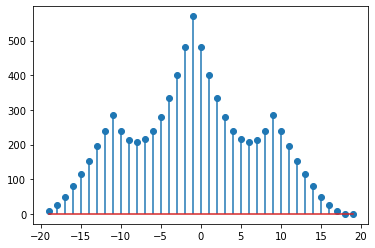

In [121]:


n = np.array([i for i in range(0,15)])
# x = 0.84**n
# y = np.roll(x,5);
# x=xxx2
# y=xxx3
x = [1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0]
y = [0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9]
# y = [2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1]
# y=x
lags,corrs_signal,bestlag = xcorr(x,y,16);
plt.figure()
plt.stem(lags,corrs_signal)
plt.show()

In [122]:
bestlag

-1

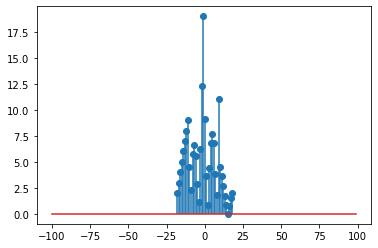

-1

In [123]:
lags, corrs,bestlag2 = correlagram(x,y,100)
plt.figure()
plt.stem(lags,abs(corrs))
plt.show()
bestlag2

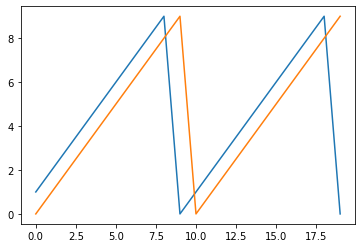

In [124]:
plt.plot(x)
plt.plot(y)

In [125]:
rr,_=st.spearmanr(x[0:-10],y[10:])
rr

0.4545454545454545

In [ ]:
signal.correlate(x, y, mode="full")

In [44]:
st.spearmanr(x,y)

SpearmanrResult(correlation=0.4545454545454546, pvalue=0.04406374785904308)

In [61]:
x[0:-9]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1]

In [62]:
y[9:]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0]